<Axes: xlabel='residual sugar', ylabel='pH'>

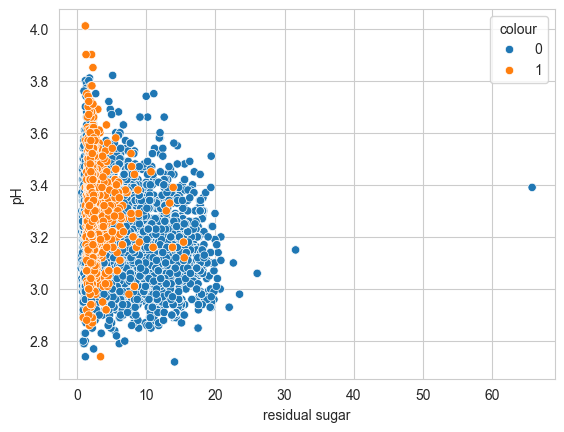

In [3]:
import pandas as pd
import seaborn as sns

wine_data_all = pd.read_csv("winequality-all.csv")

wine_data_all.head()

'''
Units for columns:
Fixed acidity (g(tararic acid) / dm^3)
Volatile acidity (g(acetic acid) / dm^3)
Citric acid (g / dm^3)
Residual sugar (g / dm^3)
Chlorides (g(sodium chloride)/dm^3)
Free sulfur dioxide (mg / dm^3)
Total sulfur dioxide (mg / dm^3)
Density (g / cm^3)
pH (dimensionless)
Sulphates (g(KSO_4) / dm^3)
Alcohol (vol.%)
Quality (subjective score between 0 and 10, 10 being the best and 0 being the worst)
Colour (Dummy variable where 1 is red and 0 is white
'''

wine_data_all.groupby('colour').describe()
def filter_drop_column(df : pd.DataFrame,condition: bool, column: str) -> pd.DataFrame:
    filtered_df = df[condition]
    return filtered_df.drop(column, axis=1)

sns.scatterplot(data=wine_data_all,x="residual sugar",y="pH", hue="colour")



In [4]:
# Identify and remove outliers for each numeric column except "colour"
numeric_columns = wine_data_all.select_dtypes(include=['number']).columns
outliers_removed_data = wine_data_all.copy()

for column in numeric_columns:
    if column != 'colour':
        # Calculate interquartile range
        q25, q75 = wine_data_all[column].quantile(0.25), wine_data_all[column].quantile(0.75)
        iqr = q75 - q25

        # Calculate the outlier cutoff
        cut_off = iqr * 2.5
        lower, upper = q25 - cut_off, q75 + cut_off

        # Identify outliers
        outliers = wine_data_all[(wine_data_all[column] < lower) | (wine_data_all[column] > upper)]

        # Remove outliers
        outliers_removed_data = outliers_removed_data[(outliers_removed_data[column] >= lower) & (outliers_removed_data[column] <= upper)]

        print(f"Column: {column}, Identified outliers: {len(outliers)}, Non-outlier observations: {len(outliers_removed_data)}")
print(wine_data_all.shape,outliers_removed_data.shape)   
outliers_removed_data.to_csv("wine_data_outliers_removed.csv")

Column: fixed acidity, Identified outliers: 140, Non-outlier observations: 6357
Column: volatile acidity, Identified outliers: 99, Non-outlier observations: 6259
Column: citric acid, Identified outliers: 29, Non-outlier observations: 6234
Column: residual sugar, Identified outliers: 5, Non-outlier observations: 6230
Column: chlorides, Identified outliers: 151, Non-outlier observations: 6097
Column: free sulfur dioxide, Identified outliers: 15, Non-outlier observations: 6082
Column: total sulfur dioxide, Identified outliers: 2, Non-outlier observations: 6081
Column: density, Identified outliers: 3, Non-outlier observations: 6081
Column: pH, Identified outliers: 5, Non-outlier observations: 6076
Column: sulphates, Identified outliers: 56, Non-outlier observations: 6049
Column: alcohol, Identified outliers: 0, Non-outlier observations: 6049
Column: quality, Identified outliers: 5, Non-outlier observations: 6044
(6497, 13) (6044, 13)


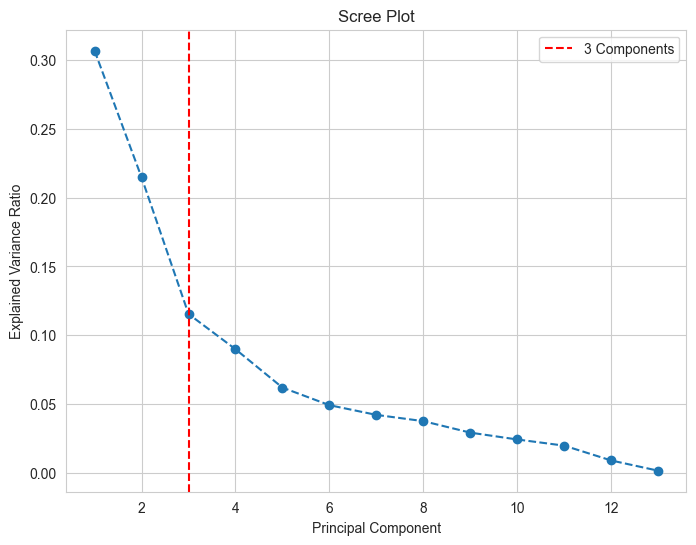

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

pca = PCA()
pca_2_component = PCA(n_components=2)
scaler = StandardScaler()
pipeline = make_pipeline(scaler, pca)
pipeline_no_quality = make_pipeline(scaler,pca_2_component)
outliers_removed_data_no_quality = outliers_removed_data.drop(columns=["quality"])
fit = pipeline.fit(outliers_removed_data)
fit_no_quality = pipeline_no_quality.fit(outliers_removed_data_no_quality)
explained_variance = pca.explained_variance_ratio_

# Create the scree plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)

# Add a vertical line at the point where the elbow is
num_components_desired = 3
plt.axvline(x=num_components_desired, color='r', linestyle='--', label=f'{num_components_desired} Components')

plt.legend()  # Add legend for the red line


loadings = pca.components_.T

# Create a DataFrame with labeled columns
num_components = loadings.shape[1]  # Number of PCA components

# Create a DataFrame with columns labeled as "PCA 1," "PCA 2," ...
pca_columns = [f'PCA {i + 1}' for i in range(num_components)]
pca_df = pd.DataFrame(loadings, columns=pca_columns)

# Add the corresponding feature names as row labels if needed
# pca_df.index = wine_data_all.columns

# Display the PCA component loadings
pca_df
plt.savefig("Scree_plot.png", dpi=300, bbox_inches='tight')


In [439]:
from sklearn.base import BaseEstimator, TransformerMixin

# Define a custom transformer to drop the "quality" column
class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop=None):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns_to_drop)


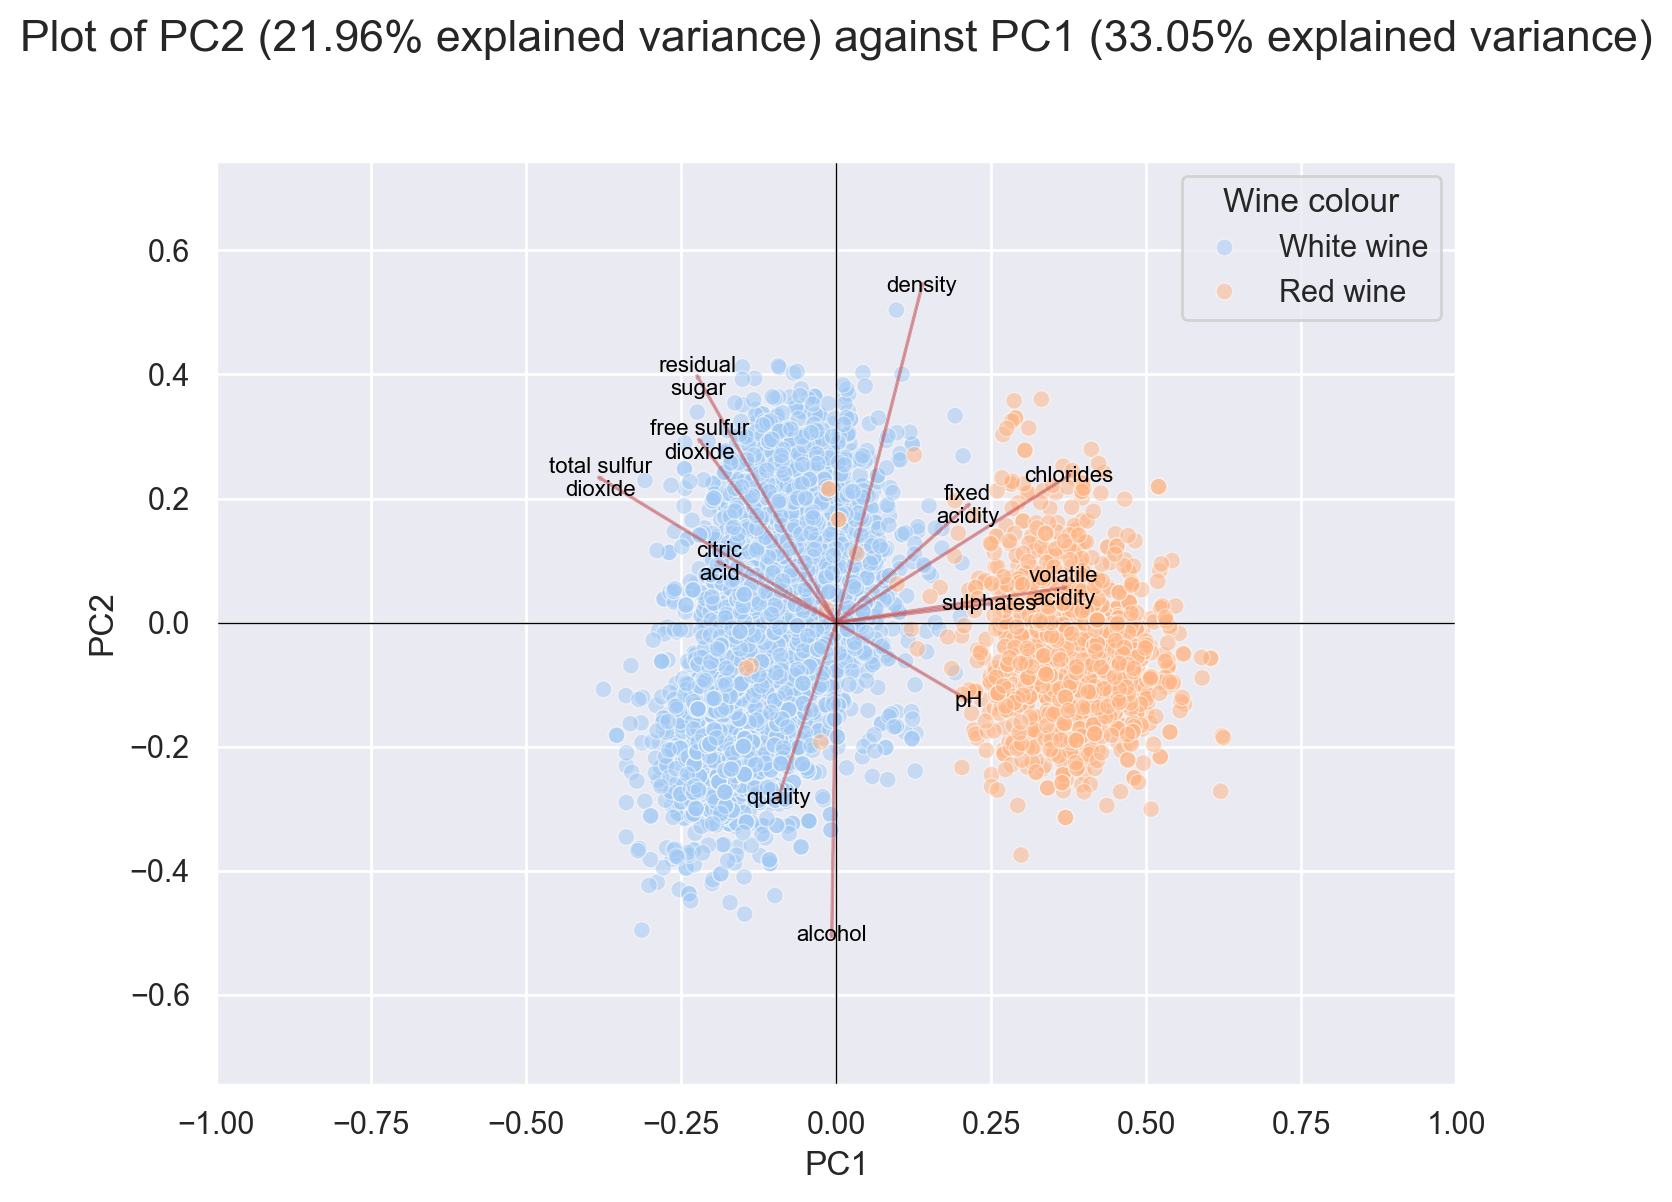

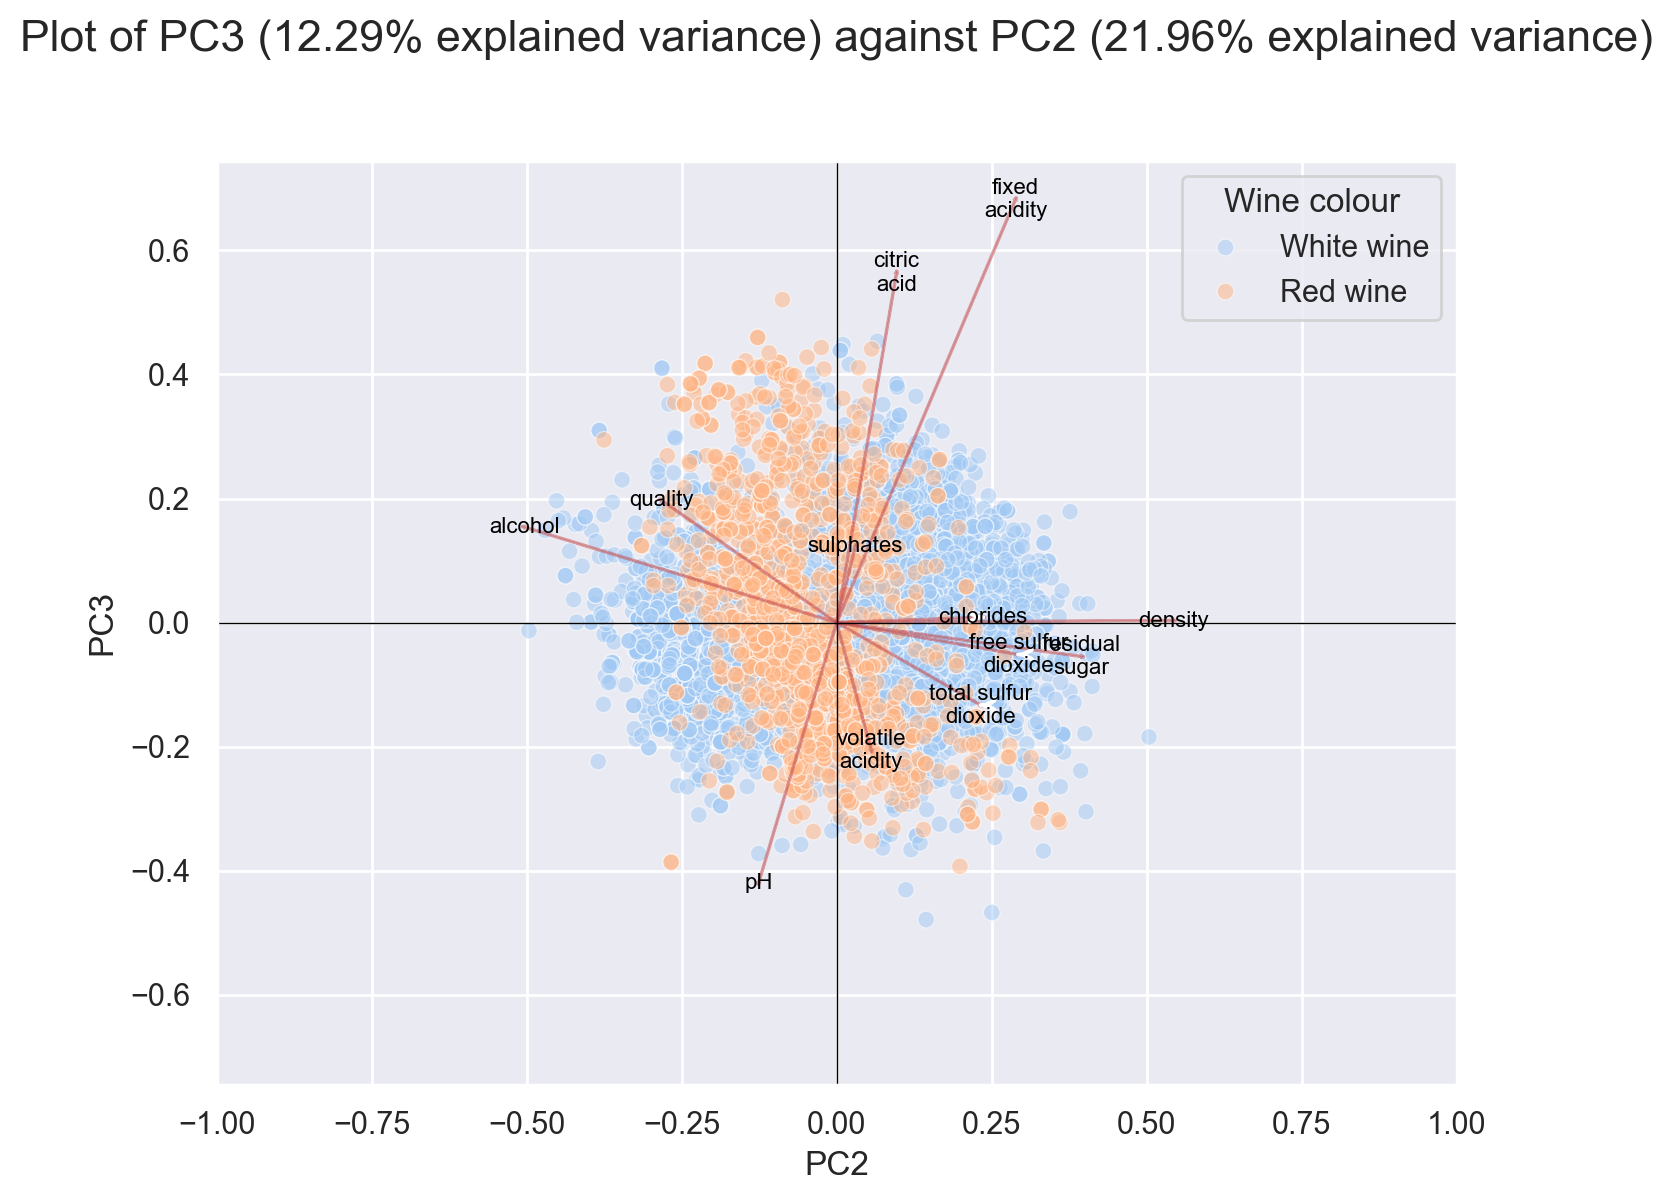

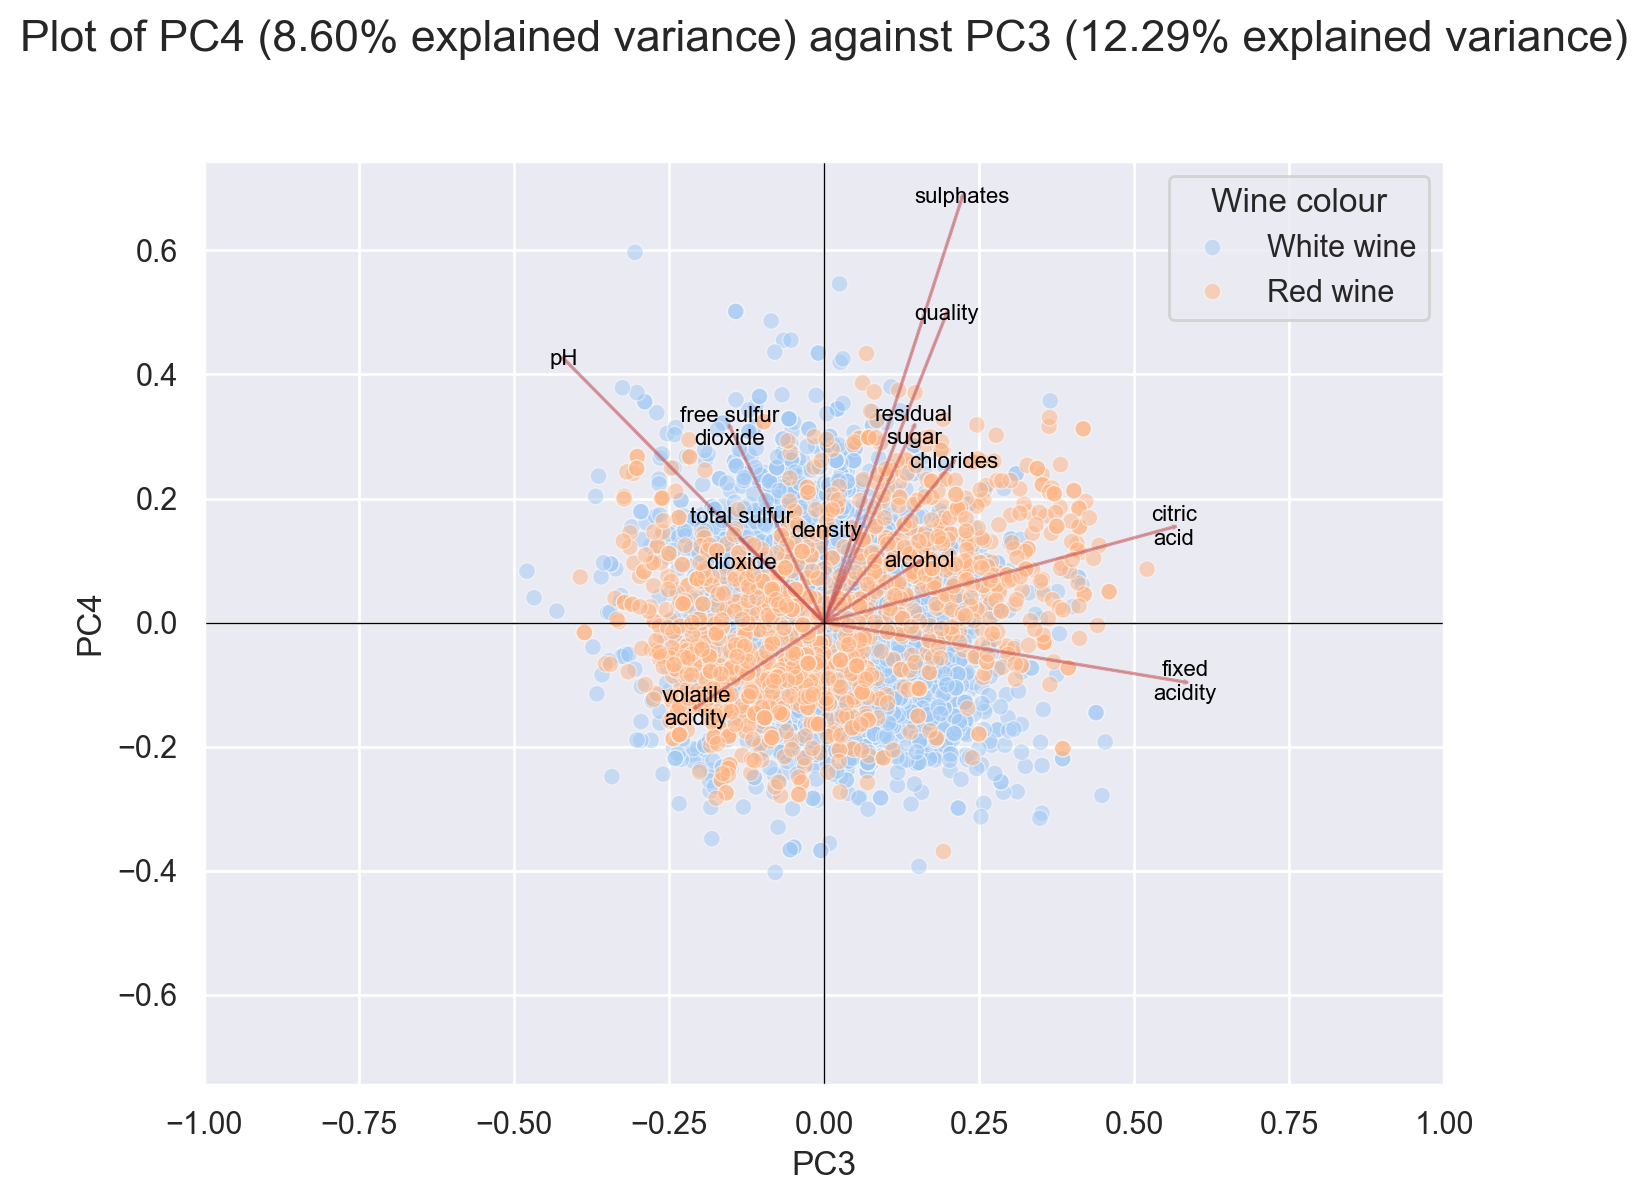

In [439]:
import matplotlib.pyplot as plt
%matplotlib inline
pca_3_component = PCA(n_components=4)
scaler = StandardScaler()
pipeline_no_quality = make_pipeline(scaler,pca_3_component)
outliers_removed_data_no_quality = outliers_removed_data.drop(columns=["quality"])
fit_no_quality = pipeline_no_quality.fit(outliers_removed_data_no_quality)
# The following %config line changes the inline figures to have a higher DPI.
%config InlineBackend.figure_format = 'retina'
plt.style.use('fast')
sns.set_palette("pastel")
'''
A function to produce biplots for PCA components. Assumes data has already been fitted with a pipeline and is available as wine_data_all. Values for fit and pca are passed in because different scopes enforce the use of references and not modifying original fit
'''
def biplot_for_pca_single(pipeline_fit: object,pca_fit: PCA, pca_number_for_x_axis : int, pca_number_for_y_axis : int,plot_title: str,figure_file_name: str) -> None:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.grid(True)
    plt.axis("equal")
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel(f"PC{pca_number_for_x_axis}")
    plt.ylabel(f"PC{pca_number_for_y_axis}")
    plt.title(plot_title, fontsize=16, y=1.1)

    # Create a new pipeline with the custom transformer and PCA
    pipeline_no_quality = make_pipeline(DropColumnsTransformer(columns_to_drop=["quality"]), StandardScaler(), pca_3_component)
    
    # Fit the pipeline with the original data (including the "quality" column)
    fit_no_quality = pipeline_no_quality.fit(outliers_removed_data)
    
    # Use the original dataset for transformation
    pca_data_x = pipeline_no_quality.transform(outliers_removed_data)[:, pca_number_for_x_axis - 1]
    pca_data_y = pipeline_no_quality.transform(outliers_removed_data)[:, pca_number_for_y_axis - 1]

    coeff = np.transpose(pca_fit.components_[pca_number_for_x_axis - 1:pca_number_for_y_axis,:])
    n=wine_data_all.shape[1]
    scale_x_axis = 1.0 / (pca_data_x.max() - pca_data_x.min())
    scale_y_axis = 1.0 / (pca_data_y.max() - pca_data_y.min())
    # Used for differentiating the wine type
    sns.scatterplot(x=pca_data_x*scale_x_axis, y=pca_data_y*scale_y_axis, hue=outliers_removed_data['colour'], alpha=0.5)
    # Generate the legend
    # Make a point with no data, modifying it to display a legend
    legend = ax.legend(title='Wine colour', loc='upper right')
    legend.get_texts()[0].set_text("White wine")
    legend.get_texts()[1].set_text("Red wine")
    for column_index in range(n-1):
        x_position = coeff[column_index, 0]
        y_position = coeff[column_index, 1]
    
        # Check if the label will overlap with others, and adjust position if needed
        if column_index < n:
            for j in range(column_index + 1, n-1):
                if (abs(x_position - coeff[j, 0]) < 0.1) and (abs(y_position - coeff[j, 1]) < 0.1):
                    x_position += 0.1
                    y_position += 0.1
    
        label = outliers_removed_data.T.index[column_index]
    
        # Find the last space character and replace it with a newline
        last_space_index = label.rfind(" ")
        if last_space_index >= 0:
            # Add an extra new line for total sulfur dioxide so labels don't overlap
            if pca_number_for_y_axis == 4 and column_index == 6:
                label = label[:last_space_index] + "\n\n" + label[last_space_index+1:]
            label = label[:last_space_index] + "\n" + label[last_space_index+1:]
    
        ax.arrow(0, 0, x_position, y_position, color="r", alpha=0.5)
        # Add arrowheads to labels
        ax.annotate(label, (x_position, y_position), color="black",
                     arrowprops=dict(arrowstyle="->", lw=1.5),
                     fontsize=8, ha='center', va='center')

    ax.axhline(0, color='black', linewidth=0.5)  # Add horizontal line
    ax.axvline(0, color='black', linewidth=0.5)  # Add vertical line


    fig.savefig(figure_file_name, dpi=300, bbox_inches='tight')
# PCA numbers are between 1 and 4, so we just need range 1 to 3, with 4 being 3 + 1.  
explained_variance_percentage = ["{:.2%}".format(num) for num in pca_3_component.explained_variance_ratio_]

for pca_number in range(1,4):
    # Create a new PCA object for each plot
    biplot_for_pca_single(fit, pca,pca_number,pca_number+1,f"Plot of PC{pca_number+1} ({explained_variance_percentage[pca_number]} explained variance) against PC{pca_number} ({explained_variance_percentage[pca_number-1]} explained variance)",f"pc{pca_number+1}_vs_pc{pca_number}_no_quality")
    

IndexError: index 12 is out of bounds for axis 0 with size 12

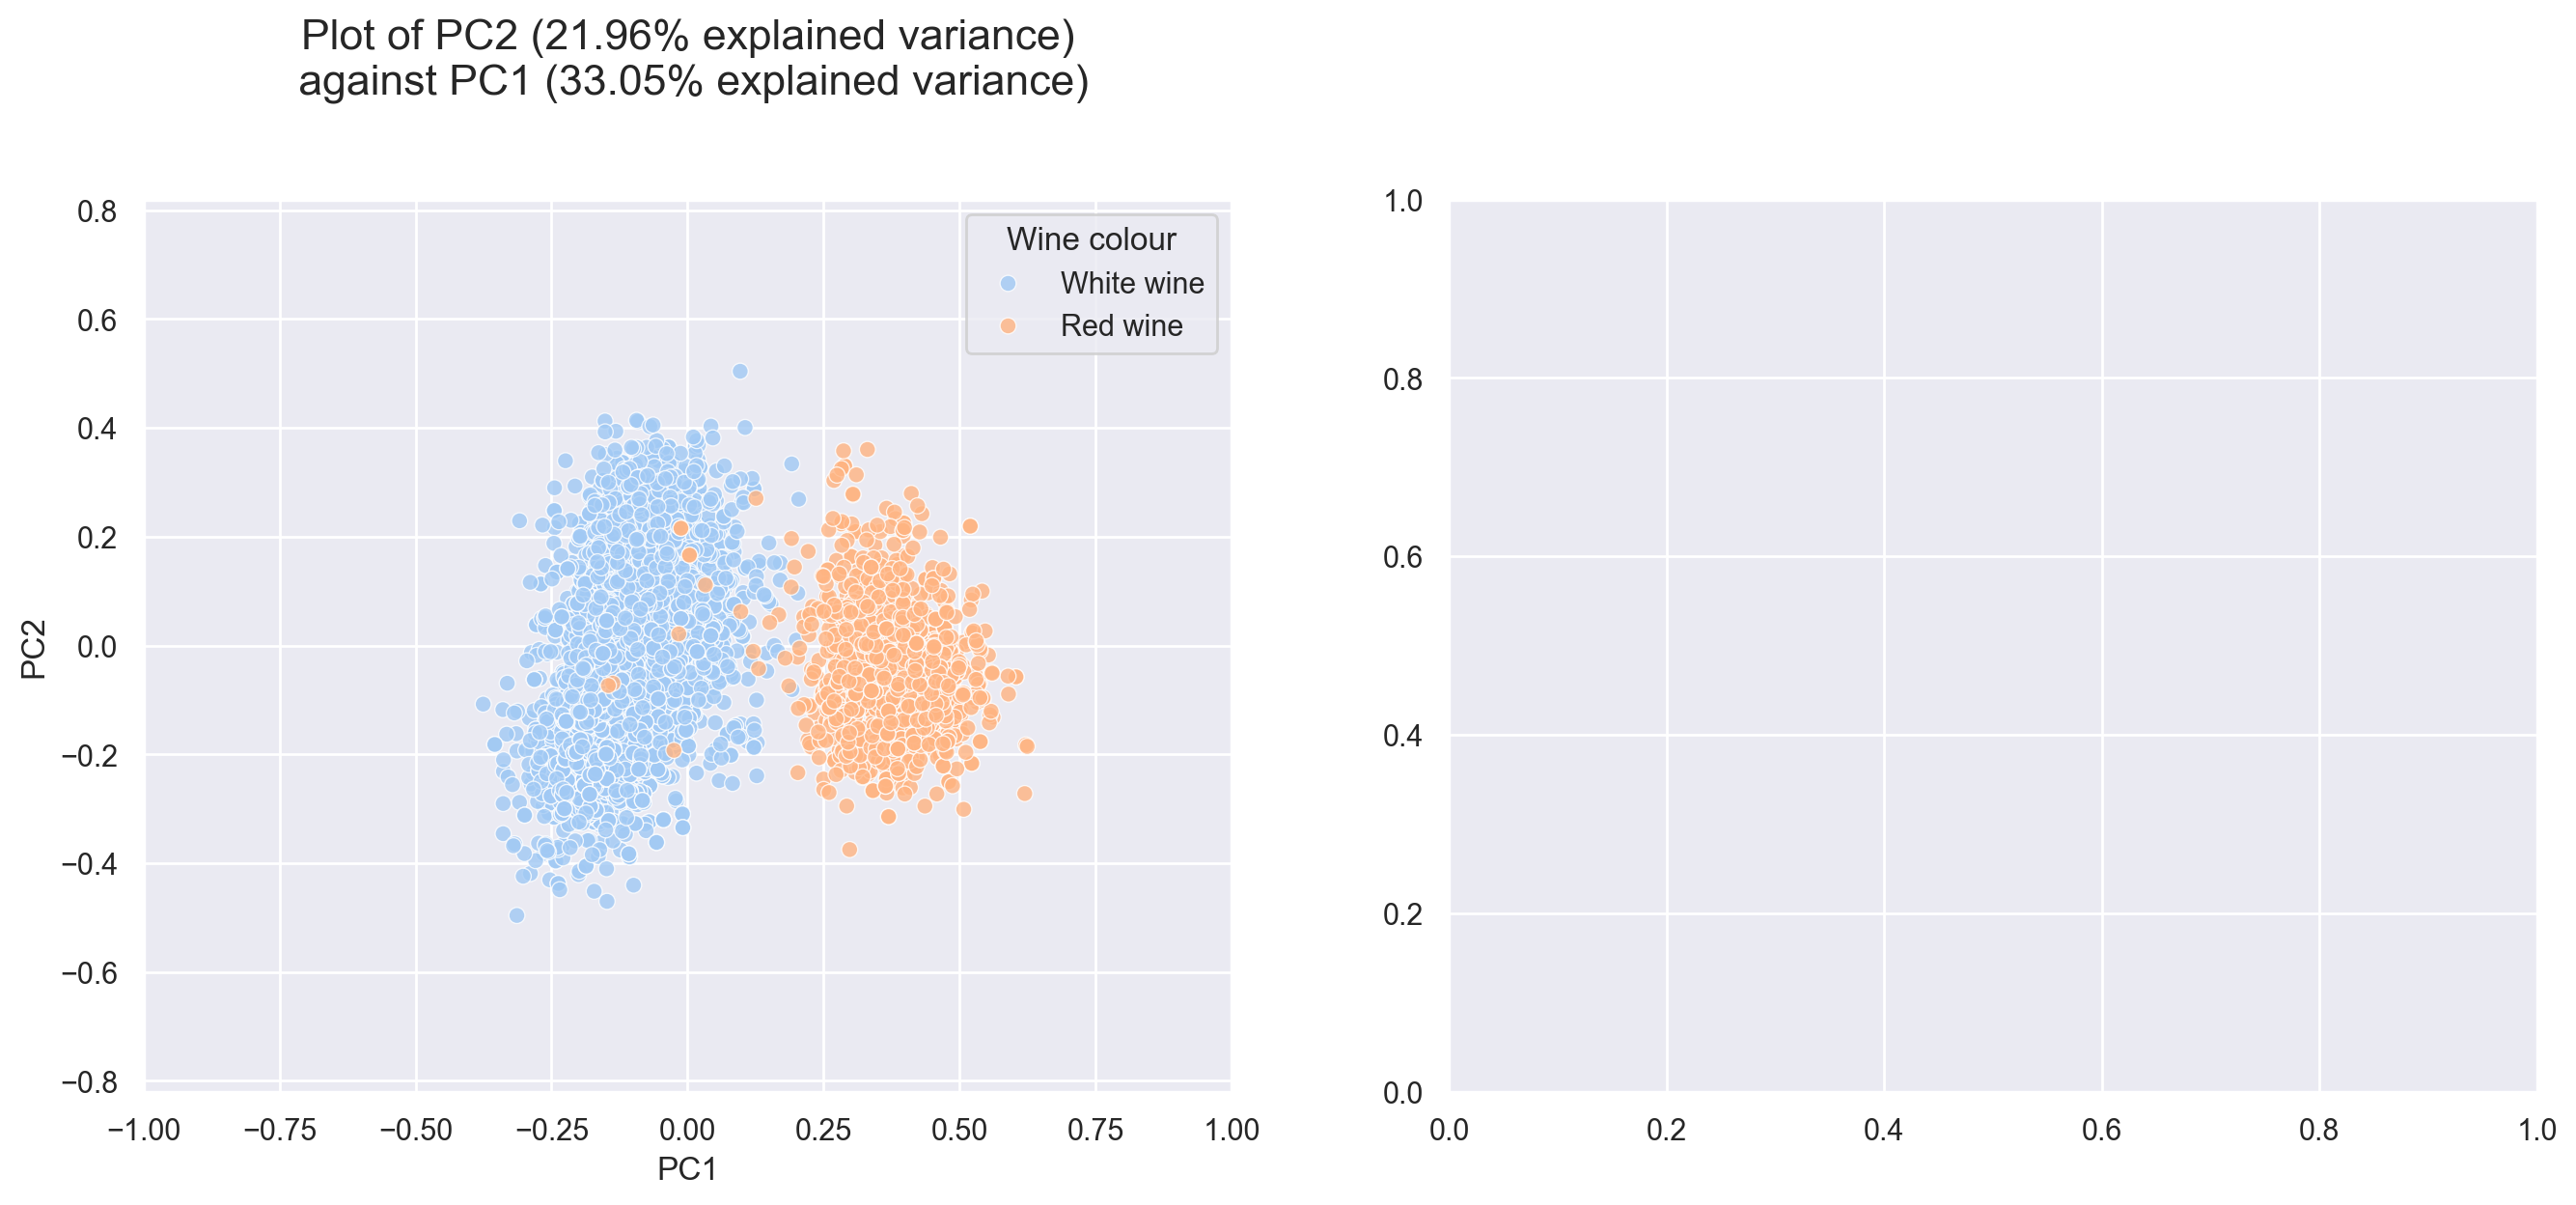

In [433]:
 import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# The following %config line changes the inline figures to have a higher DPI.
# You can comment out (#) this line if you don't have a high-DPI (~220) display.
%config InlineBackend.figure_format = 'retina'
plt.style.use('fast')
sns.set_palette("pastel")

'''
A function to produce biplots for PCA components. Assumes data has already been fitted with a pipeline and is available as wine_data_all. Values for fit and pca are passed in because different scopes enforce the use of references and not modifying the original fit
'''
def biplot_for_pca(pipeline_fit: object, pca_fit: PCA, pca_number_for_x_axis: int, pca_number_for_y_axis: int, plot_title_fig_1: str, figure_file_name: str, plot_title_fig_2) -> None:
    fig, ax = plt.subplots(figsize=(16, 6), ncols=2)
    ax[0].grid(True)
    ax[1].grid(True)
    
    for axis_index, pca_number in enumerate([pca_number_for_x_axis, pca_number_for_y_axis]):
        ax[axis_index].axis("equal")
        ax[axis_index].set_xlim(-1, 1)
        ax[axis_index].set_ylim(-1, 1)
        ax[axis_index].set_xlabel(f"PC{pca_number}")
        ax[axis_index].set_ylabel(f"PC{pca_number + 1}")
        if axis_index == 0:
            ax[axis_index].set_title(plot_title_fig_1, fontsize=16, y=1.1)
        else:
            ax[axis_index].set_title(plot_title_fig_2, fontsize=16, y=1.1)
        # Extract transformed values from fit for x and y axes
        pca_data_index_x = pca_number - 1
        pca_data_index_y = pca_number + 1 - 1
        pca_data_x = pipeline_fit.transform(outliers_removed_data.drop(columns=["quality"]))[:, pca_data_index_x]
        pca_data_y = pipeline_fit.transform(outliers_removed_data.drop(columns=["quality"]))[:, pca_data_index_y]
        coeff = np.transpose(pca_fit.components_[pca_data_index_x:pca_data_index_y + 1, :])
        n = wine_data_all.shape[1]
        scale_x_axis = 1.0 / (pca_data_x.max() - pca_data_x.min())
        scale_y_axis = 1.0 / (pca_data_y.max() - pca_data_y.min())
        
        # Used for differentiating the wine type
        sns.scatterplot(x=pca_data_x * scale_x_axis, y=pca_data_y * scale_y_axis, hue=outliers_removed_data['colour'], alpha=0.8, ax=ax[axis_index])
        
        # Generate the legend
        
        legend = ax[axis_index].legend(title='Wine colour', loc='upper right')
        legend.get_texts()[0].set_text("White wine")
        legend.get_texts()[1].set_text("Red wine")
        
        for column_index in range(n):
            x_position = coeff[column_index, 0]
            y_position = coeff[column_index, 1]

            # Check if the label will overlap with others, and adjust position if needed
            if column_index < n - 1:
                for j in range(column_index + 1, n):
                    if (abs(x_position - coeff[j, 0]) < 0.1) and (abs(y_position - coeff[j, 1]) < 0.1):
                        x_position += 0.1
                        y_position += 0.1

            label = outliers_removed_data.T.index[column_index]

            # Find the last space character and replace it with a newline
            last_space_index = label.rfind(" ")
            if last_space_index >= 0:
                # Add an extra new line for total sulfur dioxide so labels don't overlap
                if pca_data_index_y == 4 and column_index == 6:
                    label = label[:last_space_index] + "\n\n" + label[last_space_index + 1:]
                label = label[:last_space_index] + "\n" + label[last_space_index + 1:]

            ax[axis_index].arrow(0, 0, x_position, y_position, color="r")
            # Add arrowheads to labels
            ax[axis_index].annotate(label, (x_position, y_position), color="black",
                                     arrowprops=dict(arrowstyle="->", lw=1.5),
                                     fontsize=8, ha='center', va='center')

        ax[axis_index].axhline(0, color='black', linewidth=0.5)  # Add horizontal line
        ax[axis_index].axvline(0, color='black', linewidth=0.5)  # Add vertical line

    fig.savefig(figure_file_name, dpi=300, bbox_inches='tight')

# PCA numbers are between 1 and 3, so we just need range 1 to 2, with 3 being 2 + 1.  
explained_variance_percentage = ["{:.2%}".format(num) for num in pca.explained_variance_ratio_]
for pca_number in range(1, 2):
    # Create a new PCA object for each plot
    biplot_for_pca(fit, pca, pca_number, pca_number + 1,
                   f"Plot of PC{pca_number + 1} ({explained_variance_percentage[pca_number]} explained variance)\n against PC{pca_number} ({explained_variance_percentage[pca_number - 1]} explained variance)",
                    "biplots_combined_no_quality.png",f"Plot of PC{pca_number + 2} ({explained_variance_percentage[pca_number+2]} explained variance)\n against PC{pca_number+1} ({explained_variance_percentage[pca_number+1]} explained variance)")

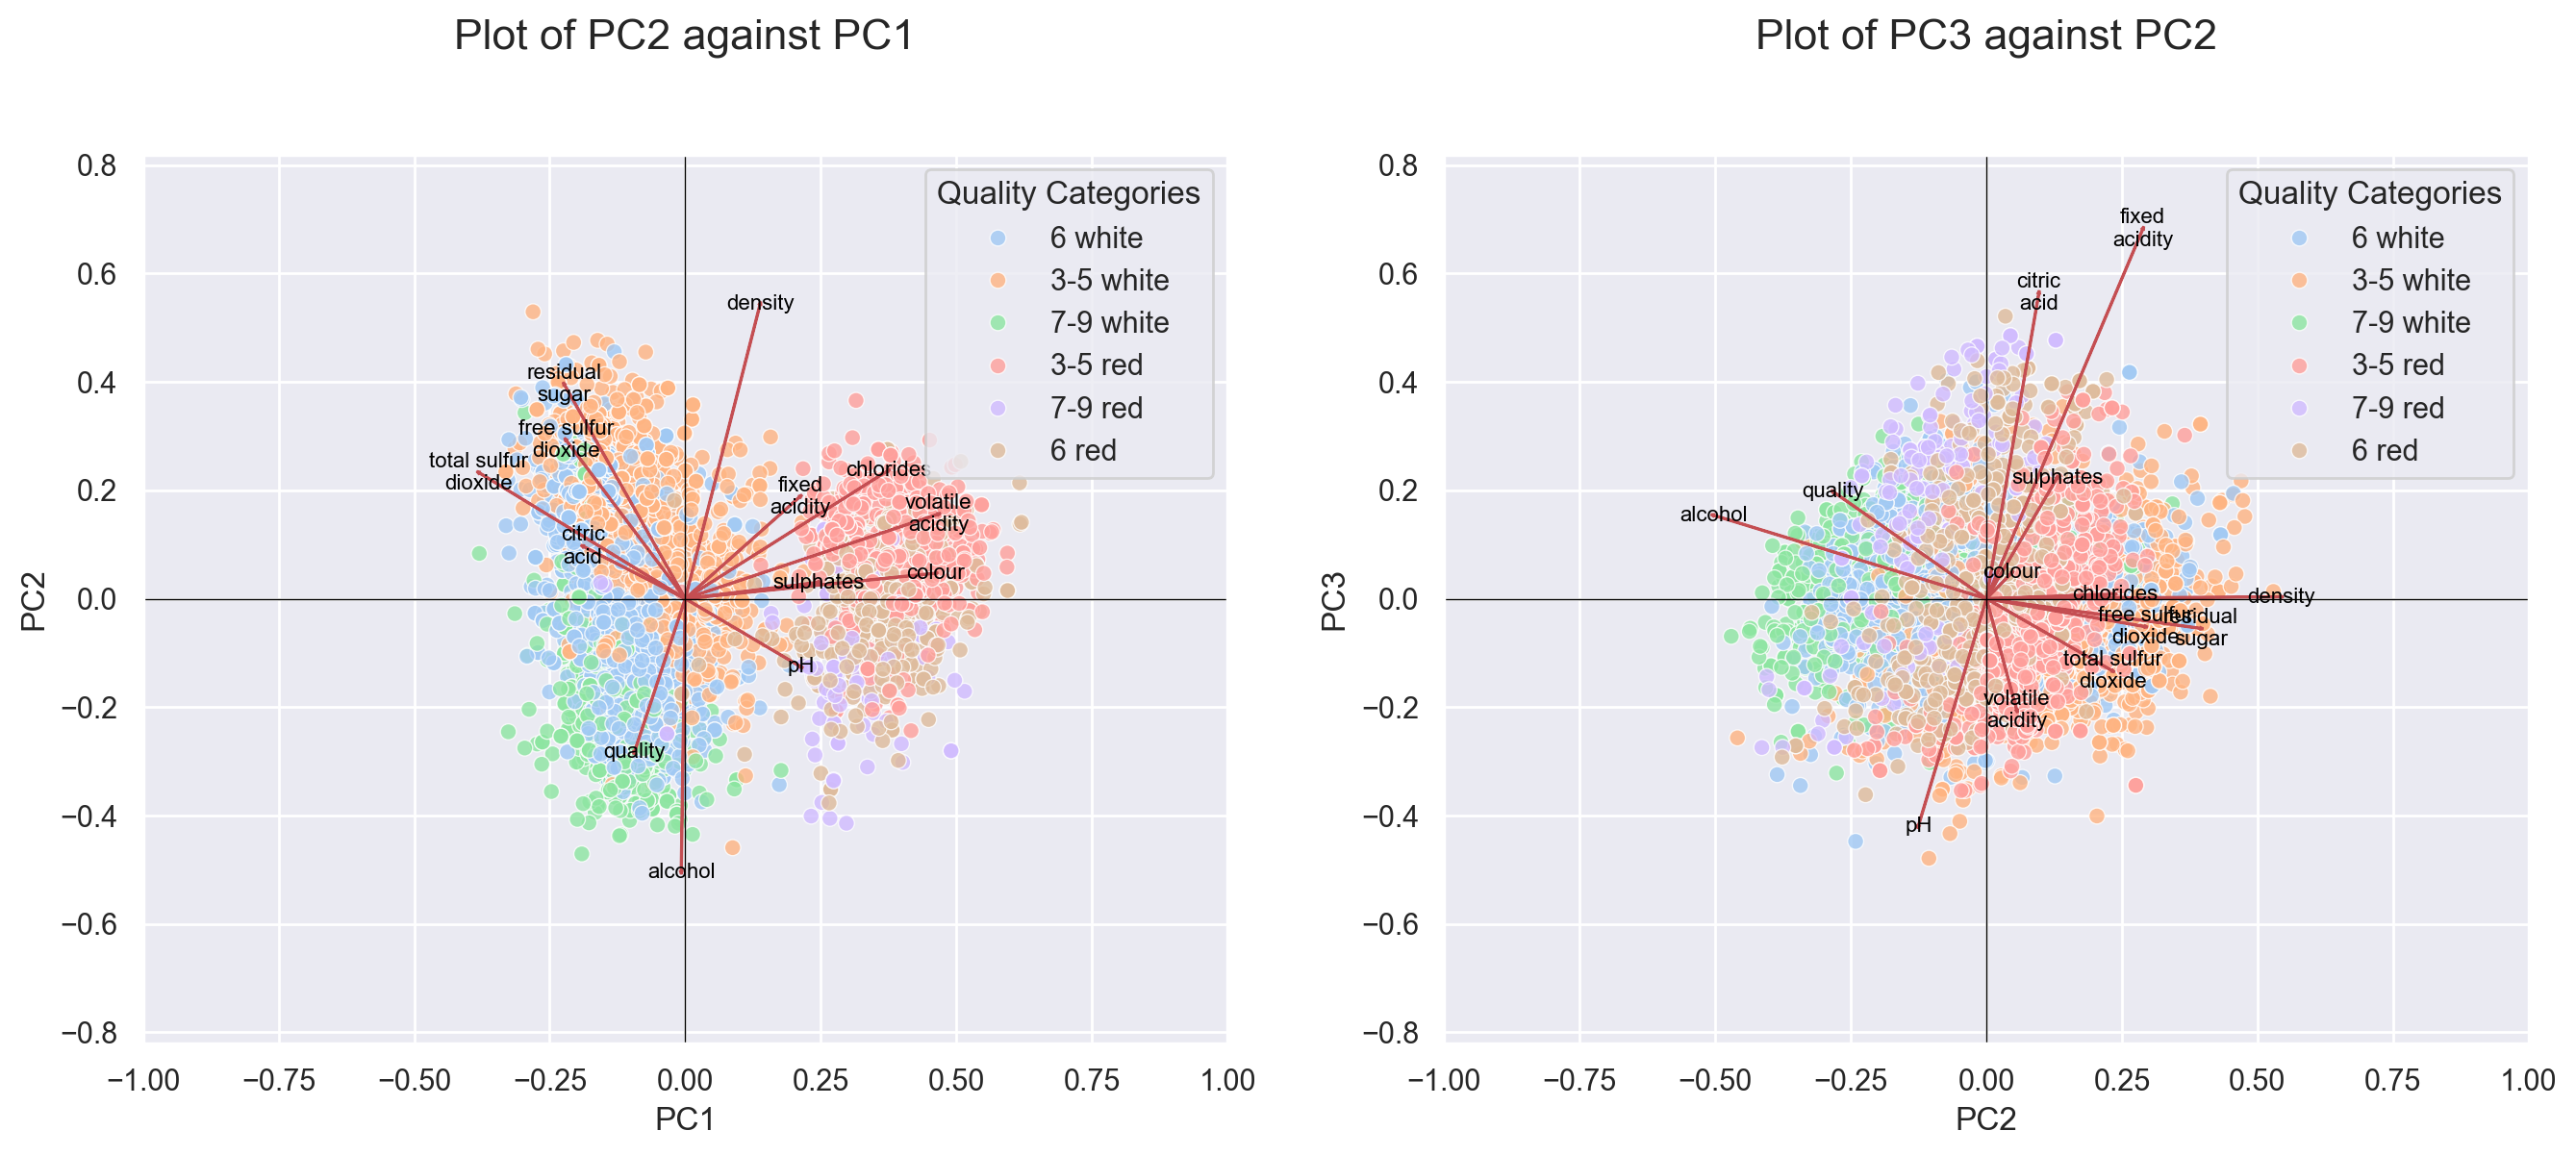

In [565]:
from sklearn.decomposition import PCA
import seaborn as sns

%matplotlib inline

# Define quality categories and corresponding colors
quality_categories = ['3-6 white', '3-6 red', '6-9 white', '6-9 red']
category_colors = {'3-6 white': 'darkcyan', '3-6 red': 'gold', '6-9 white': 'royalblue', '6-9 red': 'darkorange'}


def biplot_for_pca_quality(pipeline_fit: object, pca_fit: PCA, pca_number_for_x_axis: int, pca_number_for_y_axis: int, plot_title: str, figure_file_name: str) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Create subplots with 1 row and 2 columns
    axes = axes.flatten()  # Flatten the 2D array of axes

    for ax, pca_number in zip(axes, range(1, 3)):
        ax.grid(True)
        ax.axis("equal")
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.set_xlabel(f"PC{pca_number}")
        ax.set_ylabel(f"PC{pca_number + 1}")
        ax.set_title(f"Plot of PC{pca_number + 1} against PC{pca_number}", fontsize=16, y=1.1)

        # Create a new column based on conditions
        data_copy = deepcopy(outliers_removed_data)
        conditions = [
            (data_copy['quality'].ge(3) & data_copy['quality'].lt(6)),
            (data_copy['quality']).eq(6),
            (data_copy['quality'].ge(7) & data_copy['quality'].le(9)),
        ]

        # Define corresponding categories
        categories = ['3-5','6', '7-9']
        # Use np.select to assign categories based on conditions
        data_copy['quality_category'] = np.select(conditions, categories, default='Unknown')
        
        # Create a mapping for color and quality category combinations
        category_mapping = {
            (0, '3-5'): '3-5 white',
            (0, '6'): '6 white',
            (0, '7-9'): '7-9 white',
            (1, '3-5'): '3-5 red',
            (1, '6'): '6 red',
            (1, '7-9'): '7-9 red',
        }
        
        legend_labels = [
    '3-5 (White)',
    '6 (White)',
    '7-9 (White)',
    '3-5 (Red)',
    '6 (Red)',
    '7-9 (Red)'
]
        # Apply the mapping to create the 'quality_categories_by_wine' column
        data_copy['quality_categories_by_wine'] = data_copy[['colour', 'quality_category']].apply(tuple, axis=1).map(category_mapping)

        # Drop unnecessary columns
        data_copy = data_copy.drop(columns=['quality_category'])

        # Define the features to be scaled (excluding 'quality_categories_by_wine')
        features_to_scale = [col for col in data_copy.columns if col != 'quality_categories_by_wine']

        # Create a ColumnTransformer that applies StandardScaler to specified features
        preprocessor = ColumnTransformer(
            transformers=[
                ('scaler', StandardScaler(), features_to_scale),
            ],
            remainder='passthrough'  # Pass through columns not specified in transformers
        )

        pca_new = PCA(n_components=3)

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('pca', pca_new)
        ])

        # Exclude 'quality_categories_by_wine' during fitting
        pipeline.fit(data_copy.drop(columns=['quality_categories_by_wine']))

        transformed_data = pipeline.transform(data_copy.drop(columns=['quality_categories_by_wine']))

        # Extract transformed values from fit for x and y axes
        pca_data_index_x = pca_number - 1
        pca_data_index_y = pca_number + 1 - 1
        pca_data_x = transformed_data[:, pca_data_index_x]
        pca_data_y = transformed_data[:, pca_data_index_y]
        # Extract the components from the pipeline
        components = pipeline.named_steps['pca'].components_
        # Check if index is within bounds
        if pca_data_index_y >= components.shape[0]:  
            continue

        coeff = np.transpose(components[pca_data_index_x:pca_data_index_y + 1, :])
        n = data_copy.shape[1]
        scale_x_axis = 1.0 / (pca_data_x.max() - pca_data_x.min())
        scale_y_axis = 1.0 / (pca_data_y.max() - pca_data_y.min())
        # Your existing scatter plot code
        scatter = sns.scatterplot(x=pca_data_x * scale_x_axis, y=pca_data_y * scale_y_axis, hue=data_copy['quality_categories_by_wine'], alpha=0.8, ax=ax)



        ax.legend(title='Quality Categories', loc='upper right')

        for column_index in range(min(n, len(coeff))):
            x_position = coeff[column_index, 0]
            y_position = coeff[column_index, 1]

            # Check if the label will overlap with others, and adjust position if needed
            if column_index < n - 1:
                for j in range(column_index + 1, min(n, len(coeff))):
                    if (abs(x_position - coeff[j, 0]) < 0.1) and (abs(y_position - coeff[j, 1]) < 0.1):
                        x_position += 0.1
                        y_position += 0.1

            label = data_copy.T.index[column_index]

            # Find the last space character and replace it with a newline
            last_space_index = label.rfind(" ")
            if last_space_index >= 0:
                # Add an extra new line for total sulfur dioxide so labels don't overlap
                if pca_data_index_y == 4 and column_index == 6:
                    label = label[:last_space_index] + "\n\n" + label[last_space_index + 1:]
                label = label[:last_space_index] + "\n" + label[last_space_index + 1:]

            ax.arrow(0, 0, x_position, y_position, color="r")
            # Add arrowheads to labels
            ax.annotate(label, (x_position, y_position), color="black",
                         arrowprops=dict(arrowstyle="->", lw=1.5),
                         fontsize=8, ha='center', va='center')

        ax.axhline(0, color='black', linewidth=0.5)  # Add horizontal line
        ax.axvline(0, color='black', linewidth=0.5)  # Add vertical line

    fig.savefig(figure_file_name, dpi=300, bbox_inches='tight')

# Outside the function
for pca_number in range(1, 2):
    # Create a new PCA object for each plot
    pca_new = PCA(n_components=3)

    # Call the function with the specific PCA object
    biplot_for_pca_quality(fit, pca_new, pca_number, pca_number + 1,
                           f"Plot of PC{pca_number + 1} against PC{pca_number}",
                           f"wine_quality_pc{pca_number + 1}_vs_pc{pca_number}_with_quality_new")


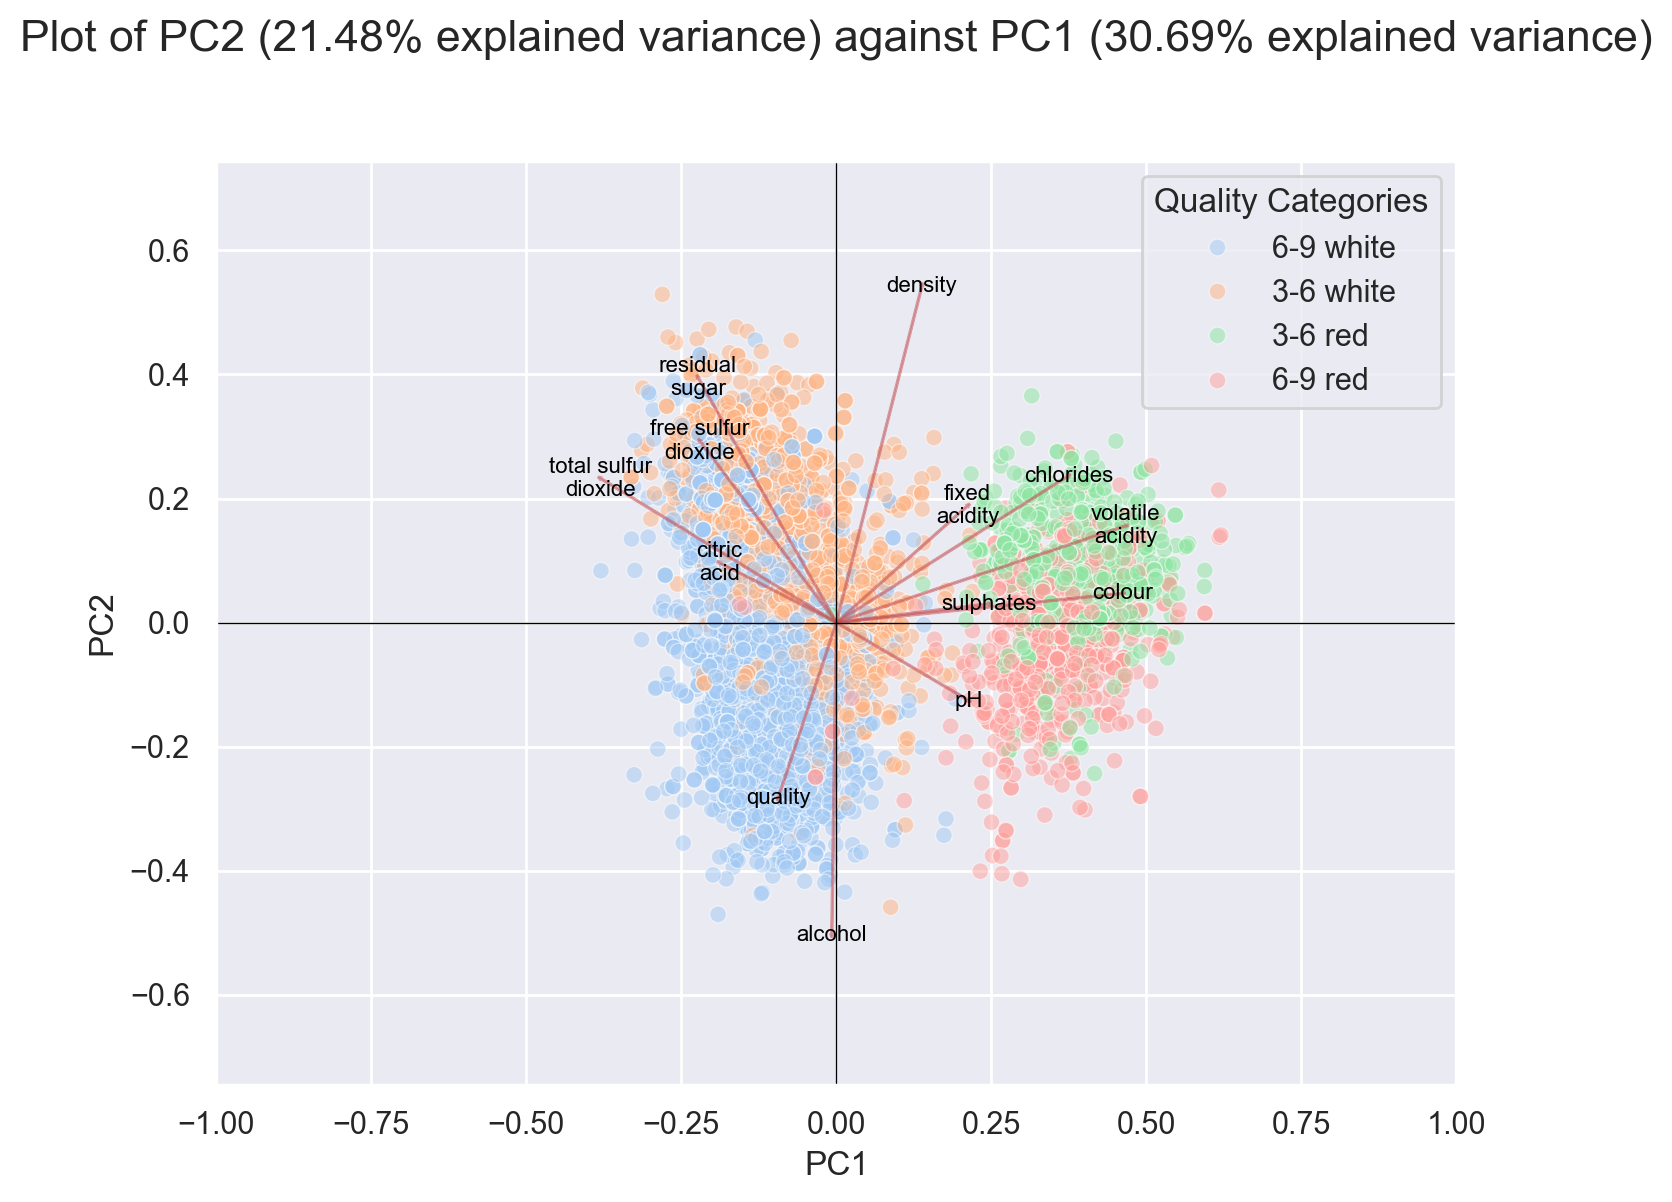

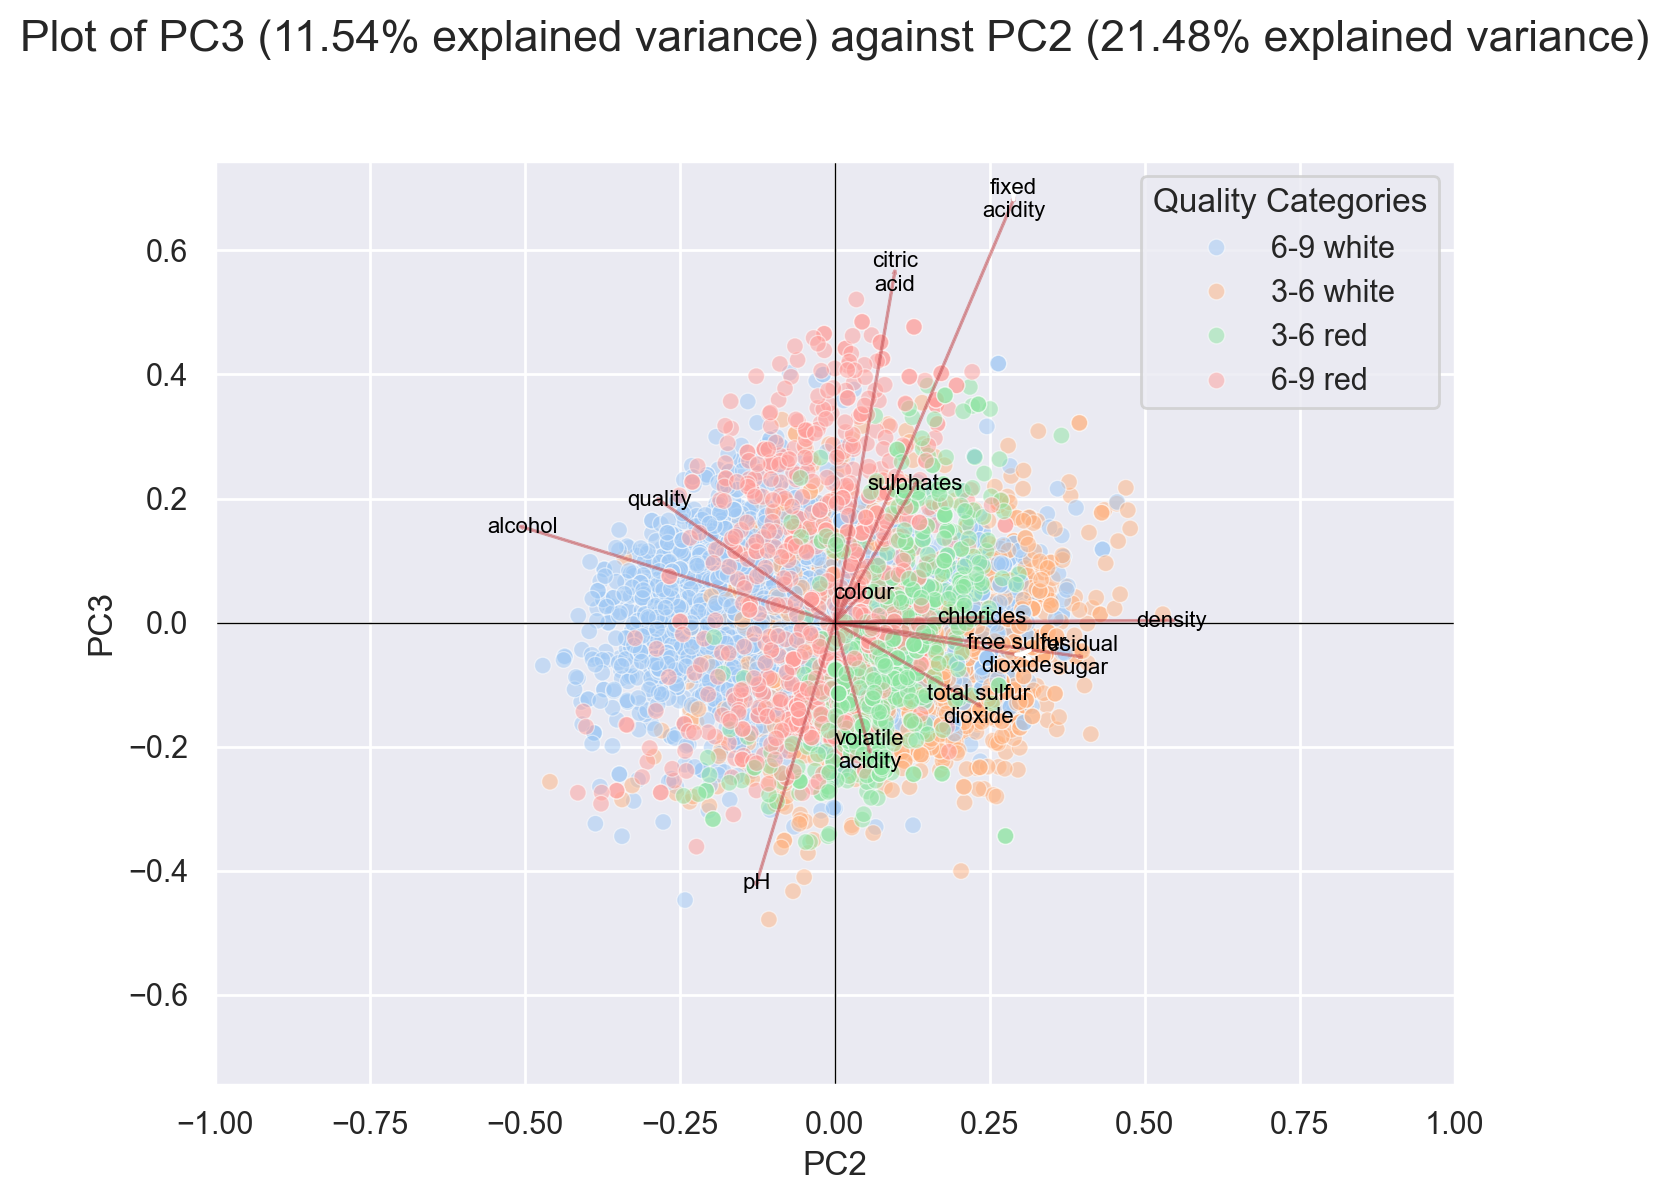

In [397]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy

%matplotlib inline

# Define quality categories and corresponding colors
quality_categories = ['3-6 white', '3-6 red', '6-9 white', '6-9 red']
category_colors = {'3-6 white': 'darkcyan', '3-6 red': 'gold', '6-9 white': 'royalblue', '6-9 red': 'darkorange'}


def biplot_for_pca_quality(pipeline_fit: object, pca_fit: PCA, pca_number_for_x_axis: int, pca_number_for_y_axis: int, plot_title: str, figure_file_name: str) -> None:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.grid(True)
    plt.axis("equal")
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel(f"PC{pca_number_for_x_axis}")
    plt.ylabel(f"PC{pca_number_for_y_axis}")
    plt.title(plot_title, fontsize=16, y=1.1)
    
    # Create a new column based on conditions
    data_copy = deepcopy(outliers_removed_data)
    # Define conditions
    conditions = [
        (data_copy['quality'].ge(3) & data_copy['quality'].lt(6)),
        (data_copy['quality'].ge(6) & data_copy['quality'].le(9)),
    ]
    
    # Define corresponding categories
    categories = ['3-6', '6-9']
    
    # Use np.select to assign categories based on conditions
    data_copy['quality_category'] = np.select(conditions, categories, default='Unknown')
    data_copy['quality_categories_by_wine'] = np.where(
        (data_copy['colour'] == 0) & (data_copy['quality_category'] == '3-6'), '3-6 white',
        np.where(
            (data_copy['colour'] == 0) & (data_copy['quality_category'] == '6-9'), '6-9 white',
            np.where(
                (data_copy['colour'] == 1) & (data_copy['quality_category'] == '3-6'), '3-6 red', '6-9 red'
            )
        )
    )

    # Drop unnecessary columns
    data_copy = data_copy.drop(columns=['quality_category'])

    # Define the features to be scaled (excluding 'quality_categories_by_wine')
    features_to_scale = [col for col in data_copy.columns if col != 'quality_categories_by_wine']

    # Create a ColumnTransformer that applies StandardScaler to specified features
    preprocessor = ColumnTransformer(
        transformers=[
            ('scaler', StandardScaler(), features_to_scale),
        ],
        remainder='passthrough'  # Pass through columns not specified in transformers
    )

    pca_new = PCA(n_components=3)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('pca', pca_new)
    ])

    # Exclude 'quality_categories_by_wine' during fitting
    pipeline.fit(data_copy.drop(columns=['quality_categories_by_wine']))

    transformed_data = pipeline.transform(data_copy.drop(columns=['quality_categories_by_wine']))

    # Extract transformed values from fit for x and y axes
    pca_data_index_x = pca_number_for_x_axis - 1
    pca_data_index_y = pca_number_for_y_axis - 1
    pca_data_x = transformed_data[:, pca_data_index_x]
    pca_data_y = transformed_data[:, pca_data_index_y]
    # Extract the components from the pipeline
    components = pipeline.named_steps['pca'].components_
    coeff = np.transpose(components[pca_data_index_x:pca_number_for_y_axis, :])
    n = data_copy.shape[1]
    scale_x_axis = 1.0 / (pca_data_x.max() - pca_data_x.min())
    scale_y_axis = 1.0 / (pca_data_y.max() - pca_data_y.min())
    # Your existing scatter plot code
    scatter = sns.scatterplot(x=pca_data_x * scale_x_axis, y=pca_data_y * scale_y_axis,hue=data_copy['quality_categories_by_wine'],alpha=0.5)


    legend_labels = [
        '3-6 (White)',
        '3-6 (Red)',
        '6-9 (White)',
        '6-9 (Red)'
    ]

    
    ax.legend(title='Quality Categories', loc='upper right')

    for column_index in range(min(n, len(coeff))):
        x_position = coeff[column_index, 0]
        y_position = coeff[column_index, 1]

        # Check if the label will overlap with others, and adjust position if needed
        if column_index < n - 1:
            for j in range(column_index + 1, min(n, len(coeff))):
                if (abs(x_position - coeff[j, 0]) < 0.1) and (abs(y_position - coeff[j, 1]) < 0.1):
                    x_position += 0.1
                    y_position += 0.1

        label = data_copy.T.index[column_index]

        # Find the last space character and replace it with a newline
        last_space_index = label.rfind(" ")
        if last_space_index >= 0:
            # Add an extra new line for total sulfur dioxide so labels don't overlap
            if pca_number_for_y_axis == 4 and column_index == 6:
                label = label[:last_space_index] + "\n\n" + label[last_space_index + 1:]
            label = label[:last_space_index] + "\n" + label[last_space_index + 1:]

        ax.arrow(0, 0, x_position, y_position, color="r", alpha=0.5)
        # Add arrowheads to labels
        ax.annotate(label, (x_position, y_position), color="black",
                     arrowprops=dict(arrowstyle="->", lw=1.5),
                     fontsize=8, ha='center', va='center')

    ax.axhline(0, color='black', linewidth=0.5)  # Add horizontal line
    ax.axvline(0, color='black', linewidth=0.5)  # Add vertical line

    fig.savefig(figure_file_name, dpi=300, bbox_inches='tight')

# Outside the function
for pca_number in range(1, 3):
    # Create a new PCA object for each plot
    pca_new = PCA(n_components=3)

    # Call the function with the specific PCA object
    biplot_for_pca_quality(fit, pca_new, pca_number, pca_number + 1,
                           f"Plot of PC{pca_number + 1} ({explained_variance_percentage[pca_number]} explained variance) against PC{pca_number} ({explained_variance_percentage[pca_number - 1]} explained variance)",
                           f"wine_quality_pc{pca_number + 1}_vs_pc{pca_number}")

In [414]:
from statsmodels.multivariate.manova import MANOVA
formula = 'Q("volatile acidity") + Q("fixed acidity") + Q("pH") ~ colour'
manova_model = MANOVA.from_formula(formula, data=outliers_removed_data)
print(manova_model.mv_test(skip_intercept_test=True))

red = wine_data_all[["volatile acidity","fixed acidity","pH"]].loc[wine_data_all["colour"] == 1]
white = wine_data_all[["volatile acidity","fixed acidity","pH"]].loc[wine_data_all["colour"] == 0]

                   Multivariate linear model
                                                                
----------------------------------------------------------------
         colour         Value  Num DF   Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda 0.3795 3.0000 6040.0000 3292.1193 0.0000
         Pillai's trace 0.6205 3.0000 6040.0000 3292.1193 0.0000
 Hotelling-Lawley trace 1.6352 3.0000 6040.0000 3292.1193 0.0000
    Roy's greatest root 1.6352 3.0000 6040.0000 3292.1193 0.0000


C:\Users\kayvo\AppData\Local\Temp\ipykernel_11904\2011931059.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['White Wine', 'Red Wine'])
C:\Users\kayvo\AppData\Local\Temp\ipykernel_11904\2011931059.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['White Wine', 'Red Wine'])
C:\Users\kayvo\AppData\Local\Temp\ipykernel_11904\2011931059.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['White Wine', 'Red Wine'])


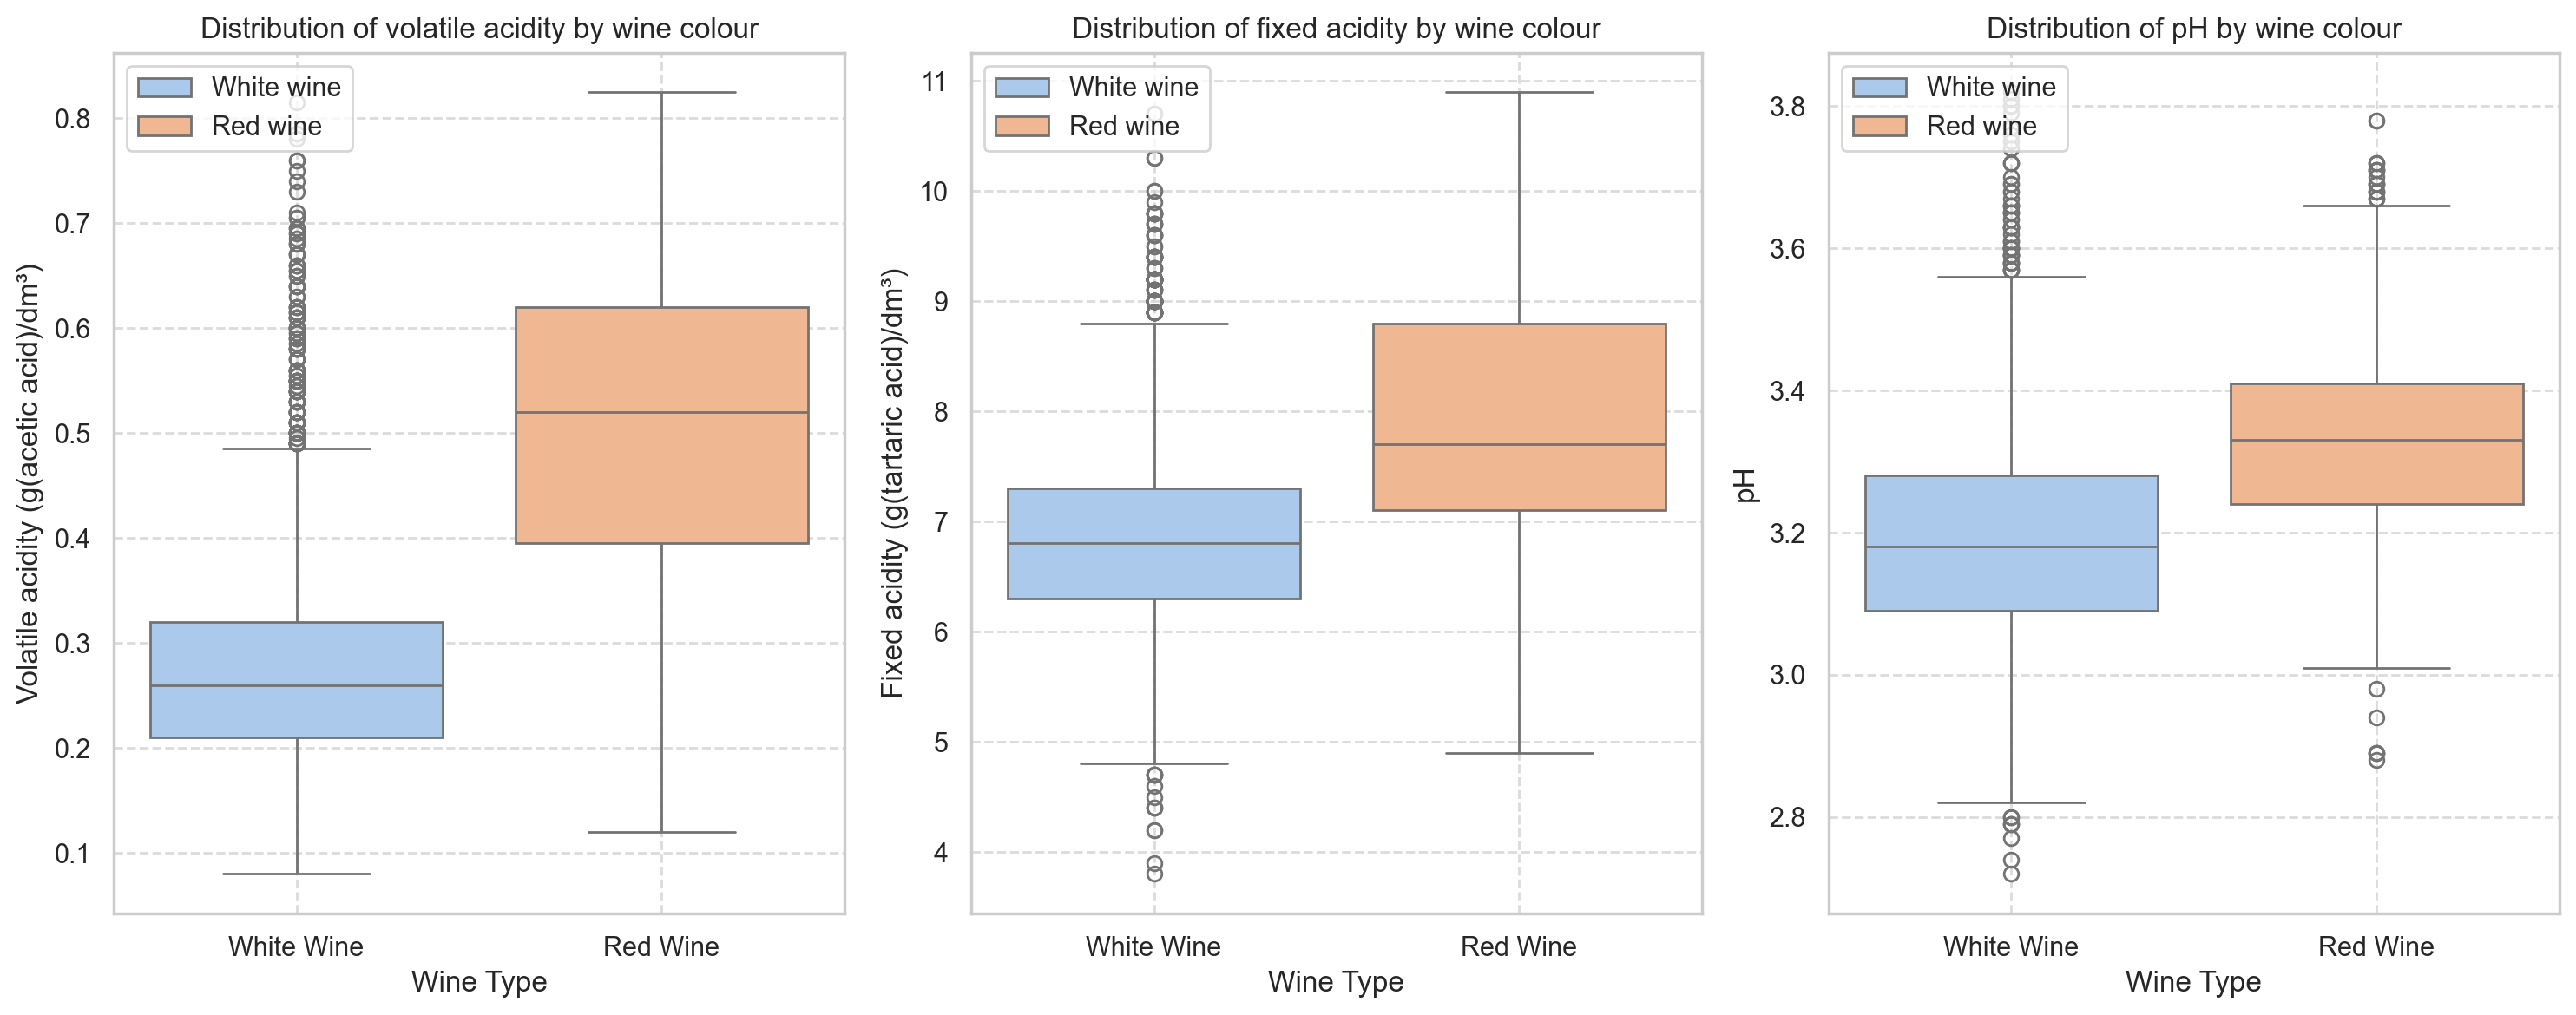

In [415]:
# Specify the order of variables
variables = ['volatile acidity', 'fixed acidity', 'pH']

# Create a 1x3 grid of box plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))  

# Iterate through each variable and create a box plot
for i, variable in enumerate(variables):
    ax = axes[i]
    sns.boxplot(x='colour', y=variable, data=outliers_removed_data, ax=ax,hue="colour")
    ax.set_title(f'Distribution of {variable} by wine colour')
    ax.set_xlabel('Wine Type')
    
    # Exclude units for pH
    if variable.lower() != 'ph':
        units = {
            'fixed acidity': 'g(tartaric acid)/dm³',
            'volatile acidity': 'g(acetic acid)/dm³',
        }
        ax.set_ylabel(f'{variable.capitalize()} ({units[variable]})')
    else:
        ax.set_ylabel(variable)
    legend = ax.legend(loc="upper left") 
    legend.get_texts()[0].set_text("White wine")
    legend.get_texts()[1].set_text("Red wine")
    # Customize x-axis labels
    ax.set_xticklabels(['White Wine', 'Red Wine'])

    # Show grid lines
    ax.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

# Save the figure
fig.savefig("box_plots_for_hotelling_two_sample.png", dpi=300, bbox_inches='tight')

In [567]:
from typing import Union
from scipy.stats import f
'''
A function that calculates CIs for hotelling t-test for a given sig level. For two populations, supply the dataframe to group_2.
'''
def hotelling_t_test_ci(group_1:pd.DataFrame, group_2 = Union[pd.DataFrame, None], sig_level=0.05) -> dict:
    # Calculate group sizes
    group_1_n = group_1.shape[0]
    # Can use either group 1 or 2 as they have equal number of variables
    number_of_dependent_variables = group_1.shape[1]
    # Calculate means for each variable for each group
    group_1_means = group_1.mean()
    # Degrees of freedom for F statistic
    df1 = number_of_dependent_variables
    df2 = group_1_n - df1
    group_1_cov = group_1.cov()
    if group_2 is not None:
        group_2_n = group_2.shape[0]
        group_2_means = group_2.mean()
        total_n = group_1_n + group_2_n
        df2 = total_n - number_of_dependent_variables - 1
        covariance_matrix = ((group_1_n - 1)*group_1_cov+(group_2_n-1)*group_2.cov())/(group_1_n+group_2_n-2)
        group_mean_diff = group_1_means - group_2_means
        f_critical = f.ppf(1 - sig_level, df1, df2)
        # K = sqrt((np-p)/(n(n-p)) * F_crit_df1_df2_0.95 )
        k_value = np.sqrt((total_n*df1-df1)/total_n*(total_n-df1) * f_critical)
        std_err = np.sqrt(np.diag(covariance_matrix))*k_value
        # Construct the dictionary
        result = {col: (mean, std_err[i]) for i, (col, mean) in enumerate(group_mean_diff.items())}

        return result
    f_critical = f.ppf(1 - sig_level, df1, df2)
    k_value = np.sqrt((group_1_n*df1-df1)/group_1_n*(group_1_n-df1) * f_critical)
    std_err = np.sqrt(np.diag(group_1.cov()))*k_value
    # Construct the dictionary
    result = {col: (mean, std_err[i]) for i, (col, mean) in enumerate(group_1_means.items())}

    return result


In [577]:
def display_cis(hotelling_ci_func: dict) -> None:
    for key, value in hotelling_ci_func.items():
        lower_bound = "{:.2f}".format(value[0]-value[1])
        upper_bound = "{:.2f}".format(value[0]+value[1])
        print(f"{key} ({lower_bound}, {upper_bound})")
display_cis(hotelling_ci_func=hotelling_t_test_ci(red,white))
outliers_removed_data.groupby("colour")[["pH","fixed acidity","volatile acidity"]].agg("mean").diff()    

volatile acidity (-27.85, 28.35)
fixed acidity (-253.73, 256.65)
pH (-34.09, 34.34)


pH  fixed acidity  volatile acidity
colour                                           
0            NaN            NaN               NaN
1       0.142331       1.095072          0.234088

In [580]:
from statsmodels.stats.multivariate import test_mvmean
# Sulfate content interesting due to fermentation - Does red have different levels of fermentation to white?
white_wine_sulfates = outliers_removed_data.loc[outliers_removed_data["colour"] == 0]
red_wine_sulfates = outliers_removed_data.loc[outliers_removed_data["colour"] == 1][["free sulfur dioxide","total sulfur dioxide","sulphates"]]
wine_wine_sulfates_means = white_wine_sulfates[["free sulfur dioxide","total sulfur dioxide","sulphates"]].mean()
one_sample_hotelling_test = test_mvmean(red_wine_sulfates,mean_null=wine_wine_sulfates_means)
print(one_sample_hotelling_test)
# One sample hotelling t test CI
display_cis(hotelling_t_test_ci(group_1=red_wine_sulfates, group_2=None))
result = outliers_removed_data.groupby("colour")[["free sulfur dioxide", "total sulfur dioxide", "sulphates"]].agg("mean").diff().round(2)
result

statistic = 3682.534375706007
pvalue = 0.0
df = (3, 1271)
t2 = 11064.987239041102
distr = F
tuple = (3682.534375706007, 0.0)
free sulfur dioxide (-1011.28, 1043.90)
total sulfur dioxide (-3210.83, 3304.53)
sulphates (-11.16, 12.43)


free sulfur dioxide  total sulfur dioxide  sulphates
colour                                                      
0                       NaN                   NaN        NaN
1                    -18.61                -90.95       0.14

C:\Users\kayvo\AppData\Local\Temp\ipykernel_11904\2556307621.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  white_wine_mean = wine_wine_sulfates_means[i]
C:\Users\kayvo\AppData\Local\Temp\ipykernel_11904\2556307621.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  white_wine_mean = wine_wine_sulfates_means[i]
C:\Users\kayvo\AppData\Local\Temp\ipykernel_11904\2556307621.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  wh

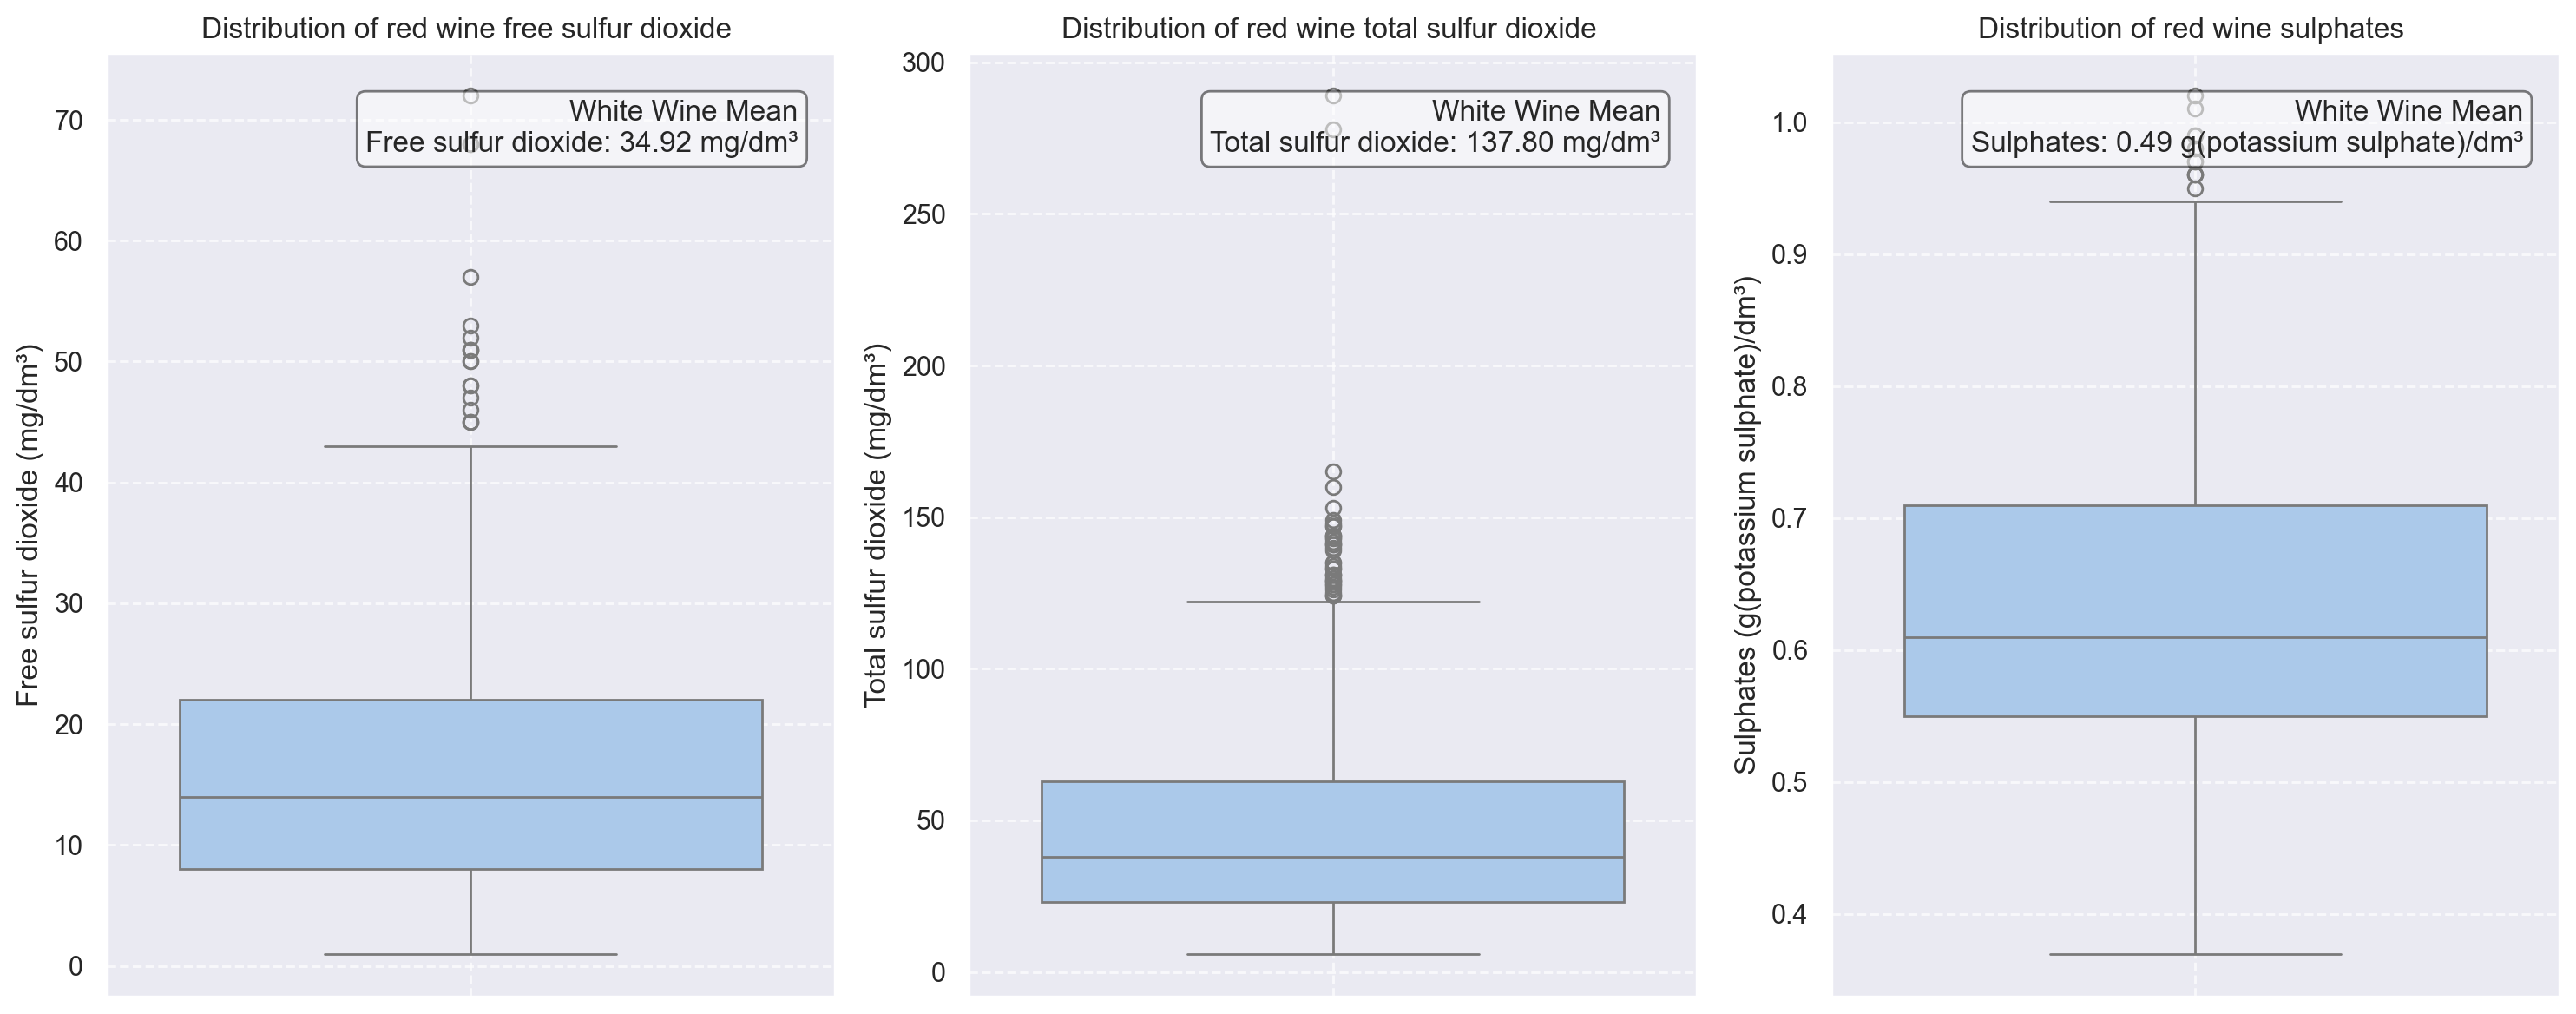

In [576]:
variables = ["free sulfur dioxide","total sulfur dioxide","sulphates"]

# Create a 1x3 grid of box plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))  # Adjusted figsize for a wider plot

# Iterate through each variable and create a box plot
for i, variable in enumerate(variables):
    ax = axes[i]
    sns.boxplot(x=i, y=variable, data=red_wine_sulfates,  ax=ax)
    ax.set_title(f'Distribution of red wine {variable} ')
    
    # Add units to y-axis label
    units = {
        'free sulfur dioxide': 'mg/dm³',
        'total sulfur dioxide': 'mg/dm³',
        'sulphates': 'g(potassium sulphate)/dm³'
    }
    ax.set_ylabel(f'{variable.capitalize()} ({units[variable]})')
    
    # Customize x-axis labels
    ax.set_xticklabels("")
    
    # Add text annotation for white wine mean
    ax.grid(True, linestyle='--', alpha=0.7)
    white_wine_mean = wine_wine_sulfates_means[i]
    box_props = dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='black')
    ax.annotate(f'White Wine Mean\n{variable.capitalize()}: {white_wine_mean:.2f} {units[variable]}', xy=(0.95, 0.95), xycoords='axes fraction', ha='right', va='top', bbox=box_props)
    ax.annotate("", xy=(0.9, 0.9), xytext=(1, 1), xycoords='axes fraction', textcoords='axes fraction')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

# Save the figure
fig.savefig("box_plots_for_hotelling_one_sample.png", dpi=300, bbox_inches='tight')

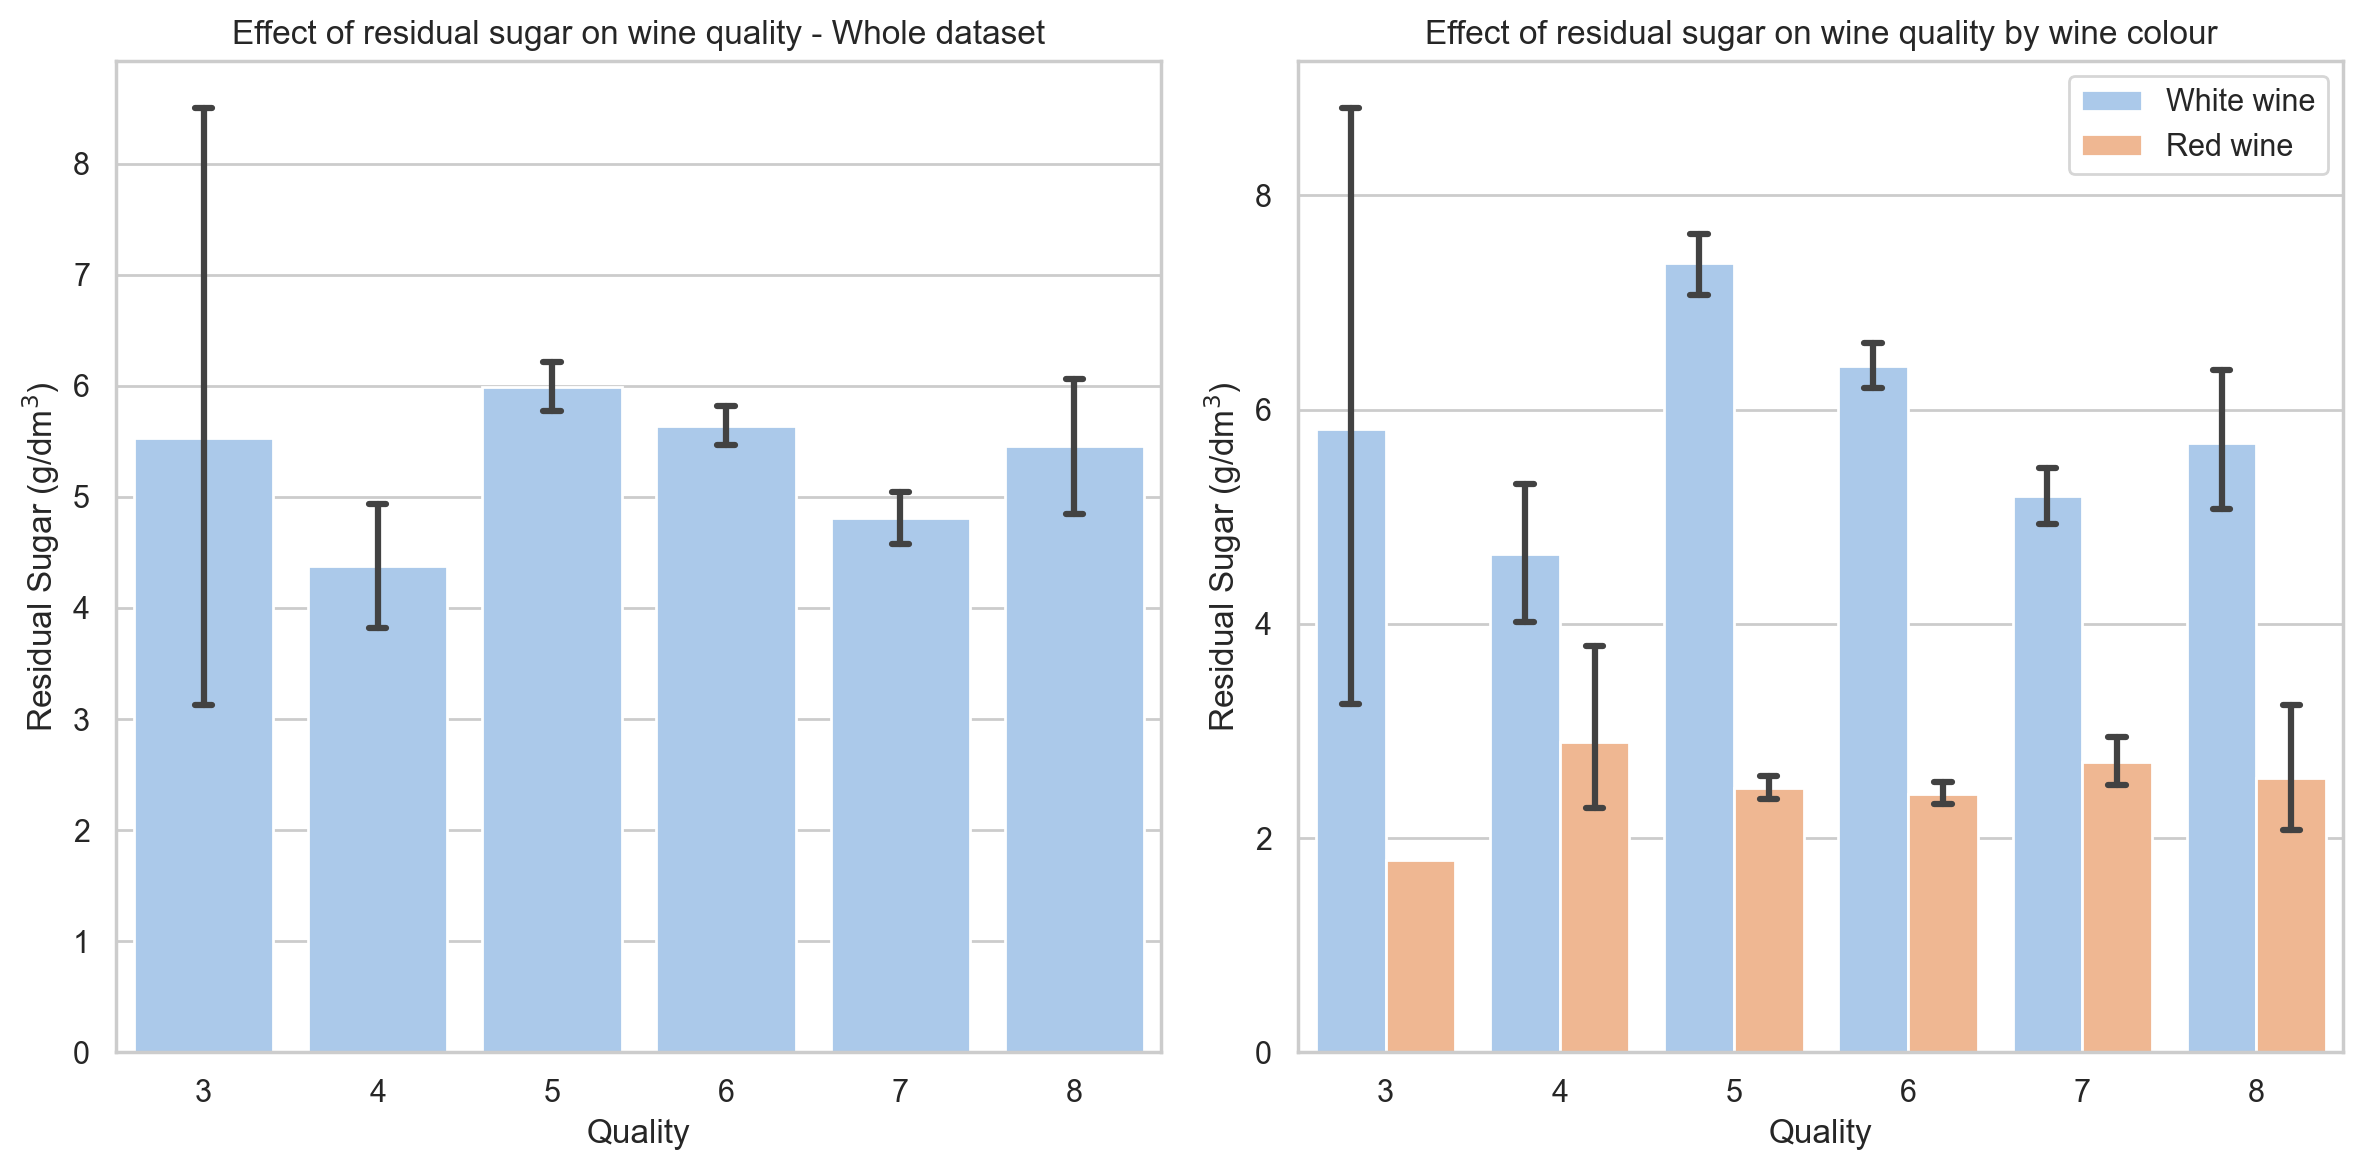

In [493]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Subplot without hue
sns.barplot(x='quality', y='residual sugar', data=outliers_removed_data, ax=axes[0], capsize=0.1)
axes[0].set_title('Effect of residual sugar on wine quality - Whole dataset')
axes[0].set_xlabel("Quality")
axes[0].set_ylabel("Residual Sugar (g/dm$^3$)")
# Subplot with hue
sns.barplot(x='quality', y='residual sugar', data=outliers_removed_data, hue='colour', ax=axes[1], capsize=0.2)
axes[1].set_title('Effect of residual sugar on wine quality by wine colour')
axes[1].set_xlabel("Quality")
axes[1].set_ylabel("Residual Sugar (g/dm$^3$)")

# Customizing legend labels
legend = axes[1].legend()
legend.get_texts()[0].set_text("White wine")
legend.get_texts()[1].set_text("Red wine")

plt.tight_layout()
plt.show()

# Save the figure
fig.savefig("whole_data_by_colour_residual_sugar_vs_quality.png", dpi=300, bbox_inches='tight')

In [ ]:
import scipy.stats
p_value_rejection_dictionary = {
    0.1 : "No evidence against H0",
    0.05 : "Weak evidence against H0",
    0.01 : "Some evidence against H0",
    0.001 : "Strong evidence against H0",
    0.0001 : "Very strong evidence against H0"
}
"""
An implementation for the box m test. Returns the p-value which can be used in assumption checking.
"""
def box_m_test(group_1: pd.DataFrame, group_2: pd.DataFrame) -> float:
    if group_1.shape[1] != group_2.shape[1]:
        raise ValueError(f"The number of dependent variables in group_1 ({group_1.shape[1]}) "
                         f"and group_2 ({group_2.shape[1]}) must be equal.")
    # Calculate group sizes
    group_1_n = group_1.shape[0]
    group_2_n = group_2.shape[0]
    # Can use either group 1 or 2 as they have equal number of variables - i.e. k value
    number_of_dependent_variables = group_1.shape[1]
    # Get the covariance matrix for both groups
    group_1_cov = group_1.cov()
    group_2_cov = group_2.cov()
    total_n = group_1_n + group_2_n
    # Calculated the pooled covariance matrix
    pooled_covariance_matrix = ((group_1_n - 1)*group_1_cov+(group_2_n-1)*group_2_cov)/(group_1_n+group_2_n-2)
    # 2 groups so m (lower case) is 2
    box_m_statistic = (total_n - 2)*np.log(np.linalg.det(pooled_covariance_matrix)) - (group_1_n*np.log(np.linalg.det(group_1_cov)) + group_2_n*np.log(np.linalg.det(group_2_cov)))
    # 2k^2 + 3k - 1 / 6(k+1)(m-1)
    critical_region_factor = (2*number_of_dependent_variables**2 + 3*number_of_dependent_variables - 1) / (6 * (number_of_dependent_variables + 1) * (2 - 1))
    # sum_{j=1}^m (where m = 2) 1/(n_j-1) - 1/(n-m), n being total_n
    critical_region_sum = 1/(group_1_n-1) - 1/(total_n-2) + 1/(group_2_n-1)
    # (2k^2 + 3k - 1 / 6(k+1)(m-1))*sum_{j=1}^m (where m = 2) 1/(n_j-1) - 1/(n-m), n being total_n
    critical_region = critical_region_factor*critical_region_sum
    # Calculate chi-square, df and p-value
    chi_square_statistic = box_m_statistic*(1-critical_region)
    df = 0.5*number_of_dependent_variables*(number_of_dependent_variables+1)*(2-1)
    p_value = scipy.stats.chi2.sf(chi_square_statistic,df)
    return p_value
'''
A function that takes in data from two groups and calculates the hotelling T-statistic for two groups for a given significance level. Checks for unequal covariances with box m test. Assumes it to be two sided and the data has been parsed in the correct format. Returns a string with the necessary information. Assumes large n for both groups. If significant, will return the confidence intervals
'''
def two_sided_hotelling_test(group_1 :  pd.DataFrame, group_2 :  pd.DataFrame, sig_level = 0.05) -> str:
    if group_1.shape[1] != group_2.shape[1]:
        raise ValueError(f"The number of dependent variables in group_1 ({group_1.shape[1]}) "
                         f"and group_2 ({group_2.shape[1]}) must be equal.")
    # Calculate group sizes
    group_1_n = group_1.shape[0]
    group_2_n = group_2.shape[0]
    # Can use either group 1 or 2 as they have equal number of variables
    number_of_dependent_variables = group_1.shape[1]
    # Calculate means for each variable for each group
    group_1_means = group_1.mean()
    group_2_means = group_2.mean()
    # Degrees of freedom for F statistic
    df1 = number_of_dependent_variables
    df2 = group_1_n + group_2_n - number_of_dependent_variables - 1
    # Find the difference between group 1 and 2 means
    vector_diff = group_1_means - group_2_means
    # Get the covariance matrix for both groups
    group_1_cov = group_1.cov()
    group_2_cov = group_2.cov()
    # Critical chi square 
    critical_chi_square = scipy.stats.chi2.ppf(sig_level,number_of_dependent_variables)
    # Check if we can assume equal covariances - if true used pooled
    box_m_test_result = box_m_test(group_1,group_2)
    if box_m_test_result <= 0.05:
        # (X-Y)^T * (V_x/n_x + V_y/n_y)^-1*(X-Y)
        hotelling_t_statistic = vector_diff@np.linalg.inv(group_1_cov/group_1_n+group_2_cov/group_2_n)@vector_diff.T
         # Assume n is sufficiently large. Assume equal number of dependent variables
        p_value = scipy.stats.chi2.sf(hotelling_t_statistic,number_of_dependent_variables)
        p_value_conclusion = "No evidence against H0"
        ci_dictionary = None
        if p_value < sig_level:
           ci_dictionary=hotelling_t_test_ci(group_1=group_1,group_2=group_2,sig_level=sig_level)
        for p_value_statement in p_value_rejection_dictionary.keys():
            if p_value < p_value_statement:
                p_value_conclusion = p_value_rejection_dictionary[p_value_statement]
        return f"""
        Hotelling T2 statistic: {hotelling_t_statistic}
        p_value: {p_value}
        Conclusion: {p_value_conclusion}
        Method: Unequal covariance approach
        Means with standard errors (None if not significant): {ci_dictionary}
        """       
    # Result was false, used alternative strategy    
    # Covariance for groups - used pooled if unbalanced
    covariance_matrix = None
    # Balanced group case
    if group_1_n == group_2_n:
        covariance_matrix = 0.5*(group_1.cov() + group_2.cov())
    else:
        covariance_matrix = ((group_1_n - 1)*group_1.cov()+(group_2_n-1)*group_2.cov())/(group_1_n+group_2_n-2)
    # Find mahalanobis distance and hotelling T statistic
    mahalanobis_distance_squared = vector_diff@np.linalg.inv(covariance_matrix)@vector_diff.T
    hotelling_t_statistic = (group_1_n*group_2_n)/(group_1_n+group_2_n) * mahalanobis_distance_squared
    # Assume n is sufficiently large. Assume equal number of dependent variables
    p_value = scipy.stats.chi2.sf(hotelling_t_statistic,number_of_dependent_variables)
    p_value_conclusion = "No evidence against H0"
    ci_dictionary = None
    if p_value < sig_level:
       ci_dictionary=hotelling_t_test_ci(group_1=group_1,group_2=group_2,sig_level=sig_level)
    for p_value_statement in p_value_rejection_dictionary.keys():
        if p_value < p_value_statement:
            p_value_conclusion = p_value_rejection_dictionary[p_value_statement]
    return f"""
    Hotelling T2 statistic: {hotelling_t_statistic}
    p_value: {p_value}
    Conclusion: {p_value_conclusion}
    Method: Equal covariance approach
    Means with standard errors (None if not significant): {ci_dictionary}
    """      

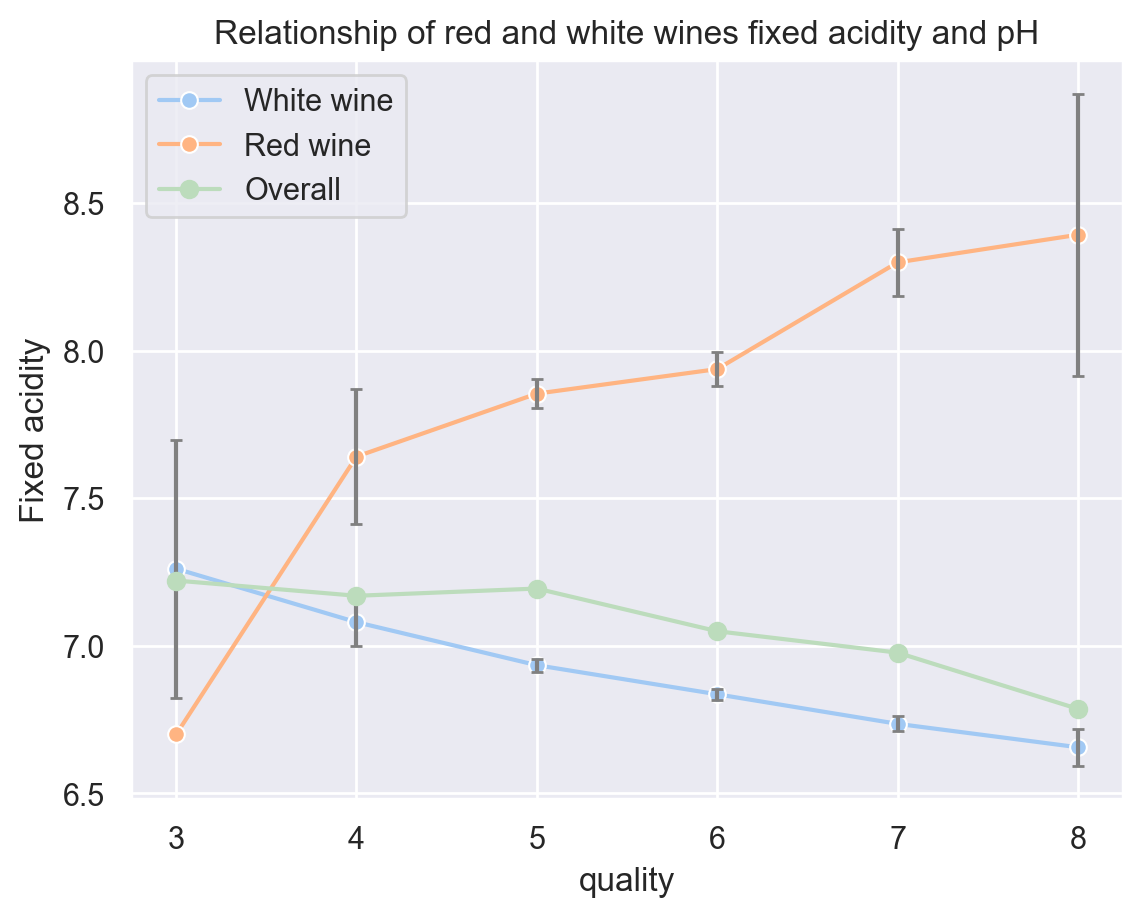

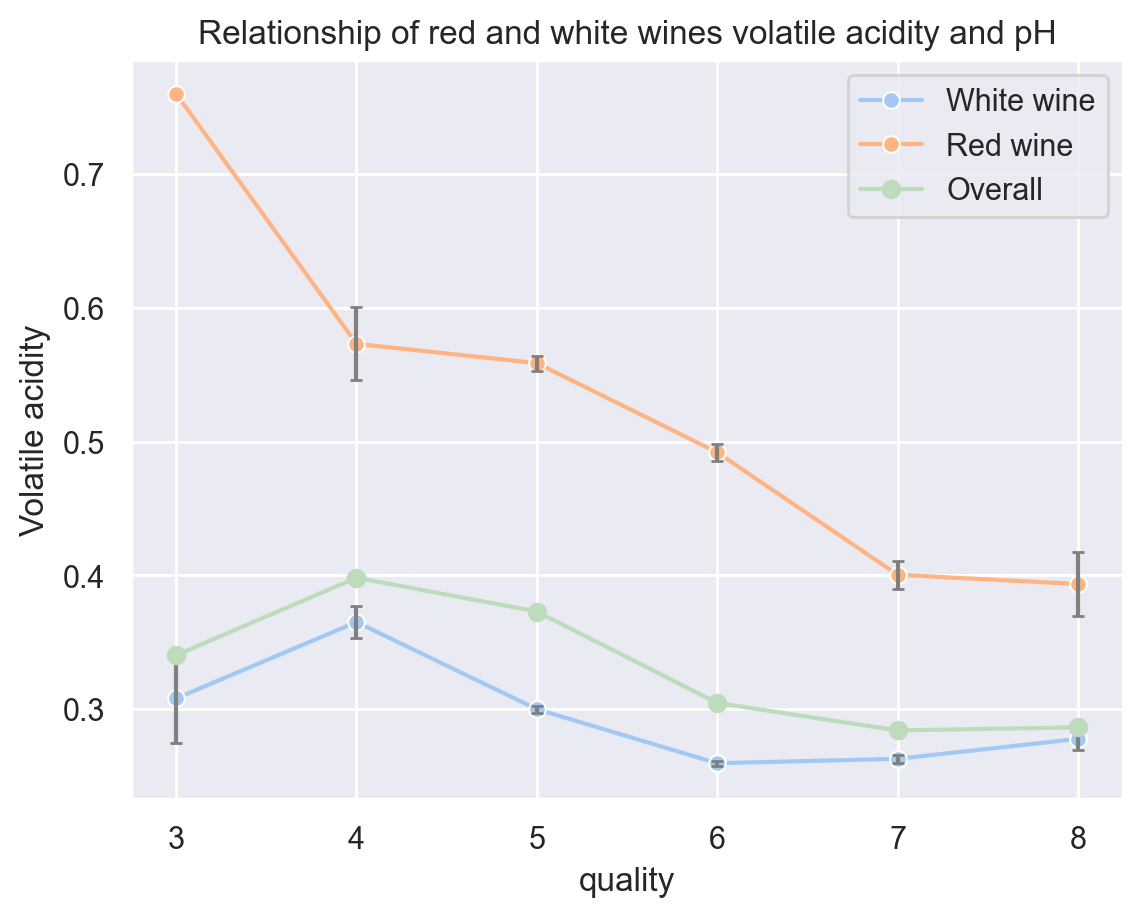

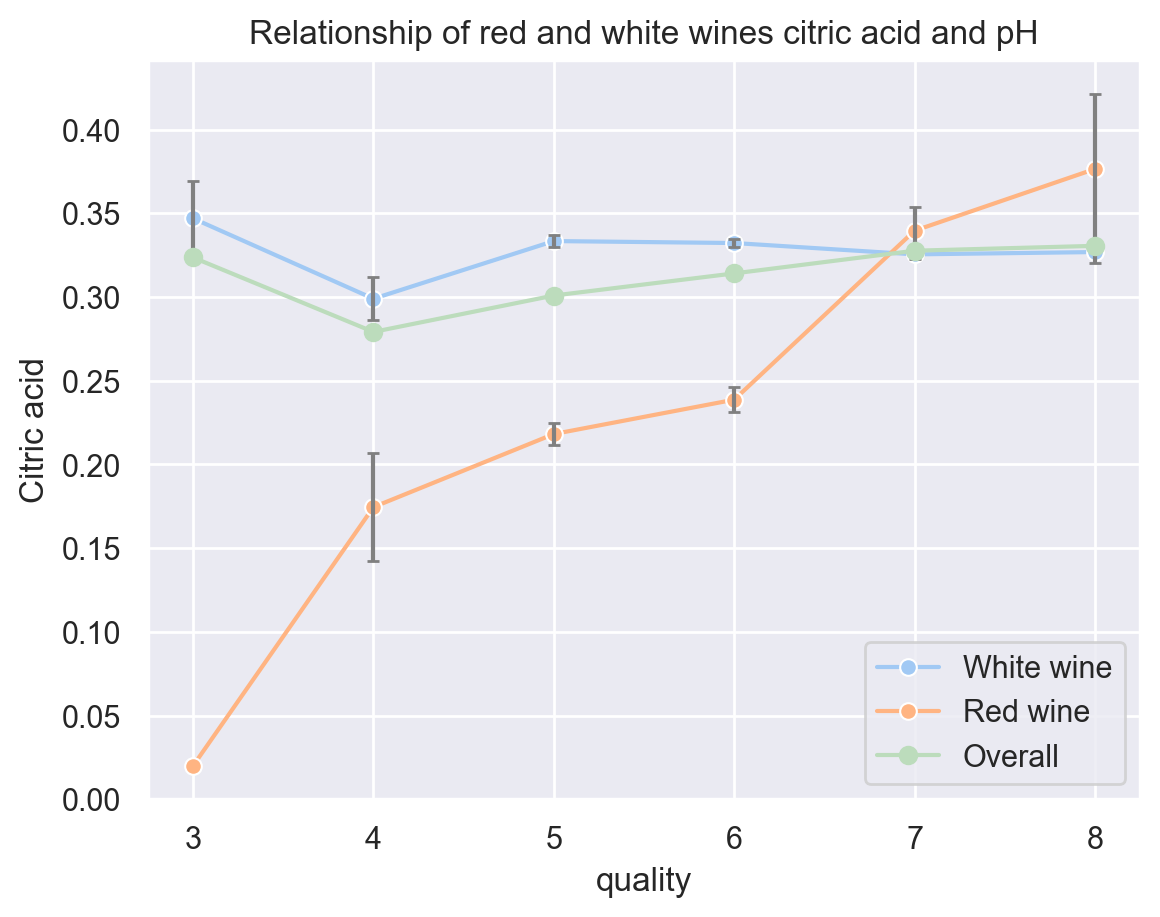

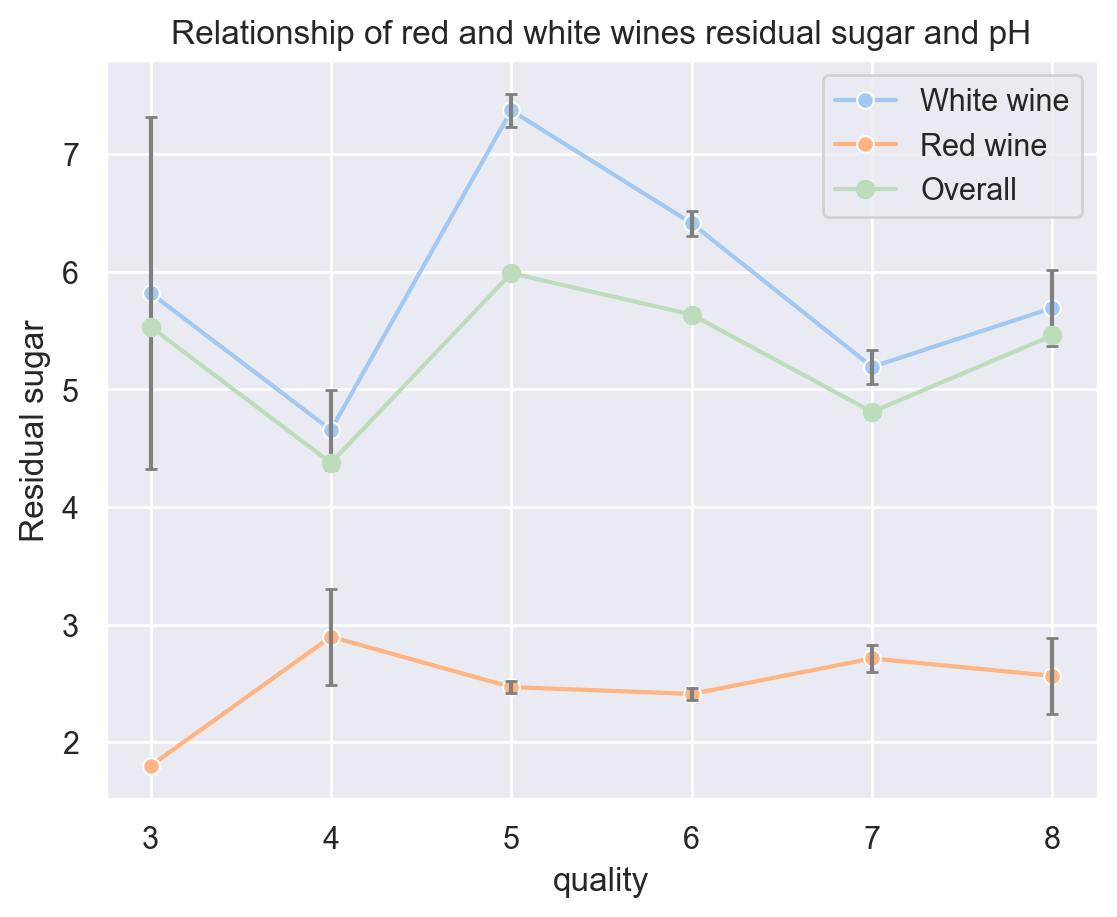

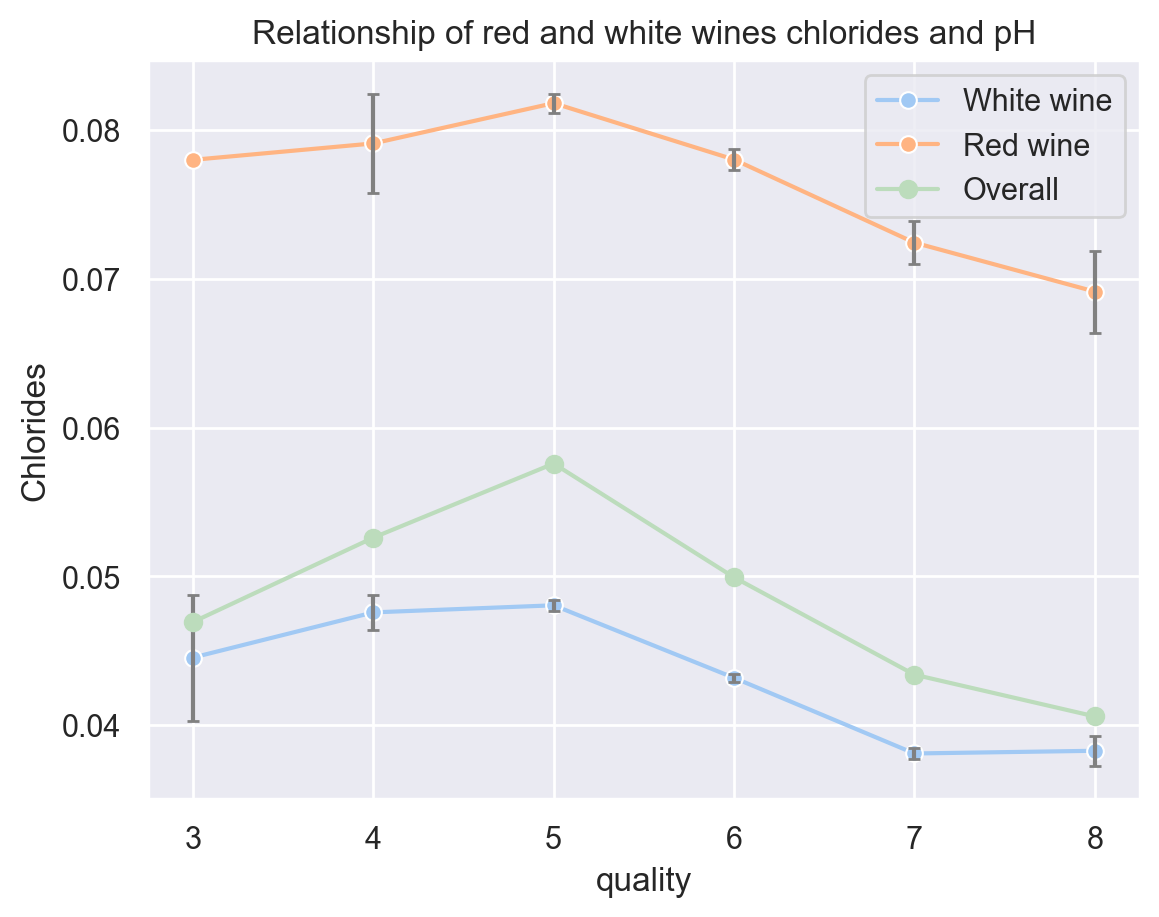

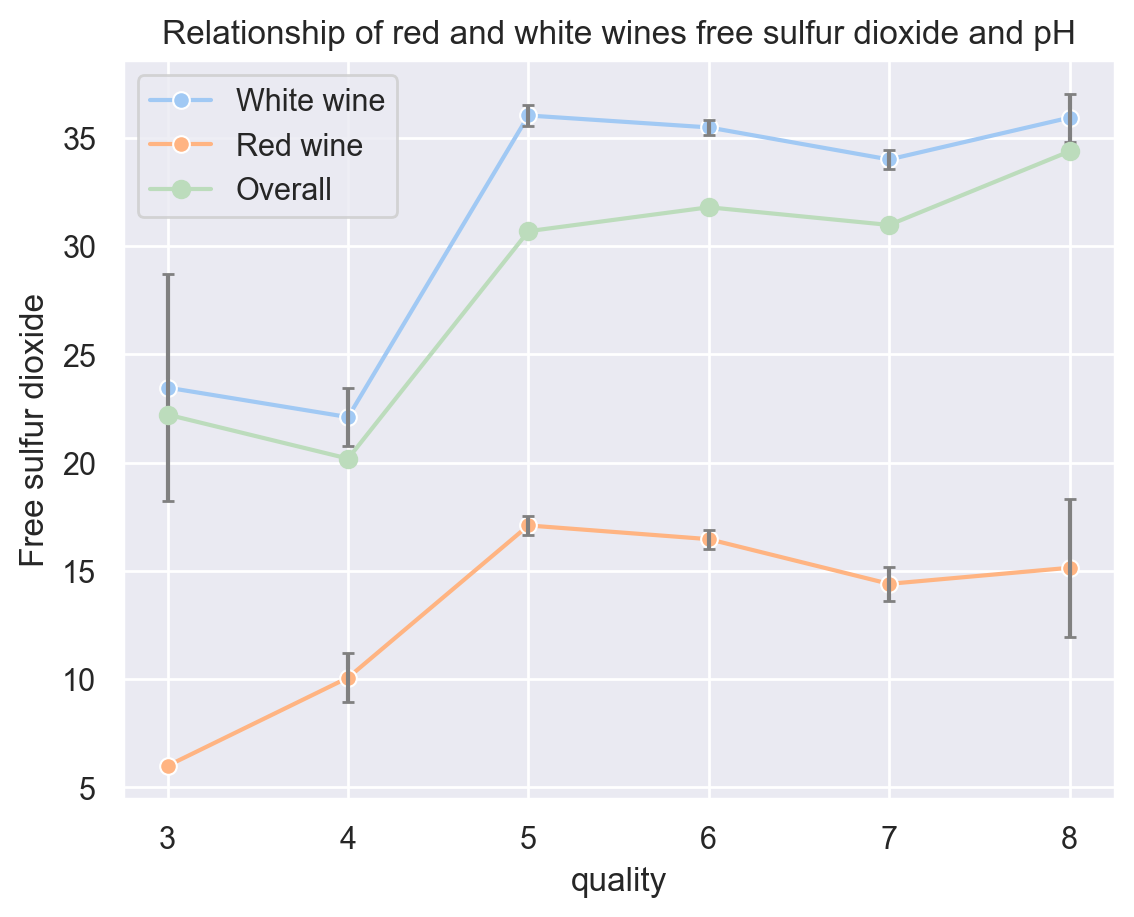

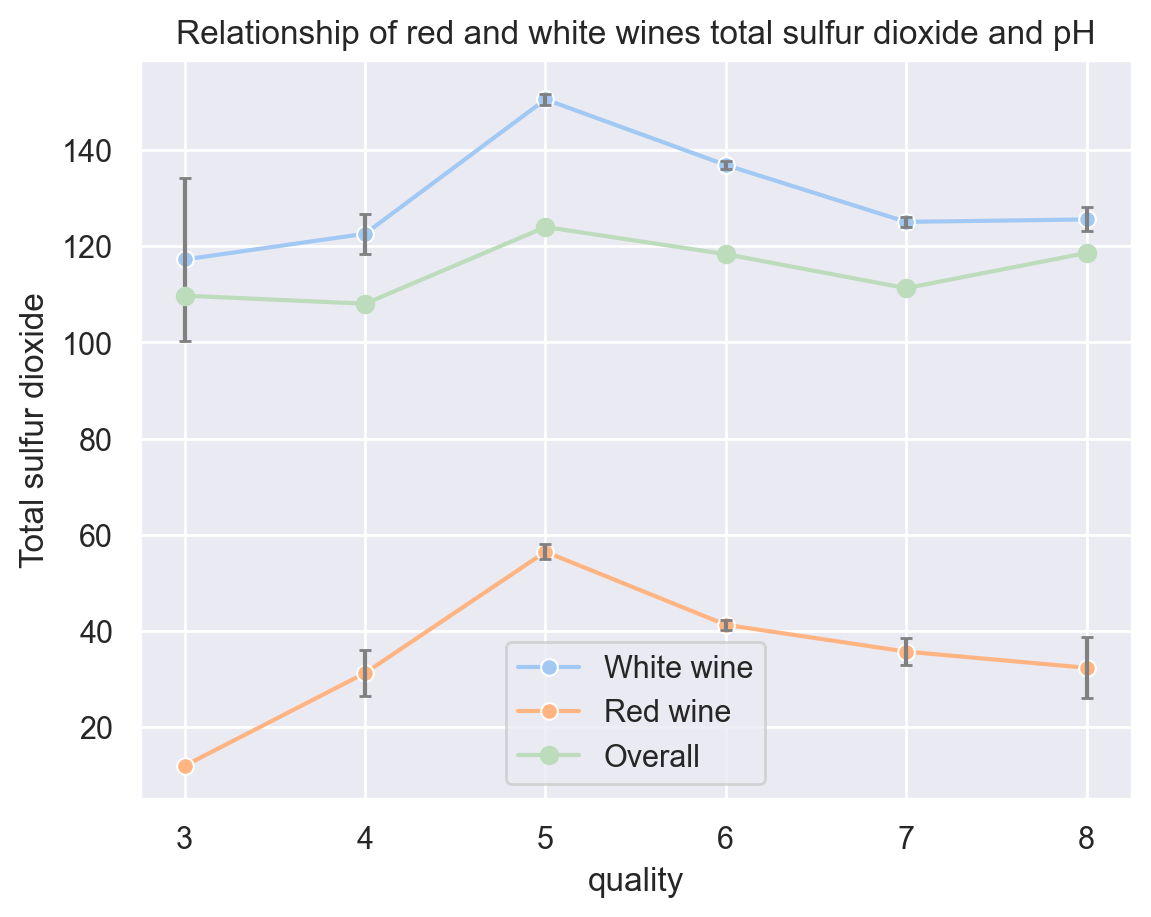

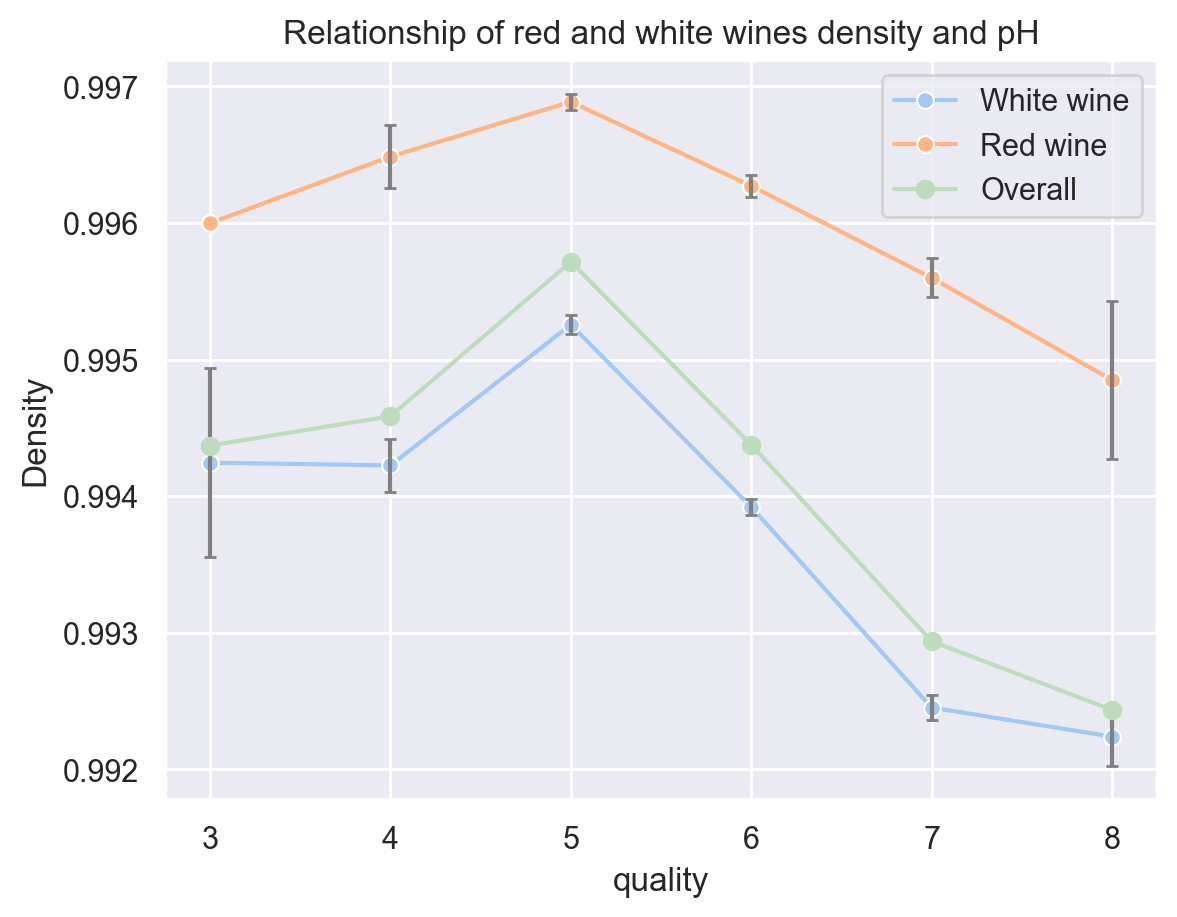

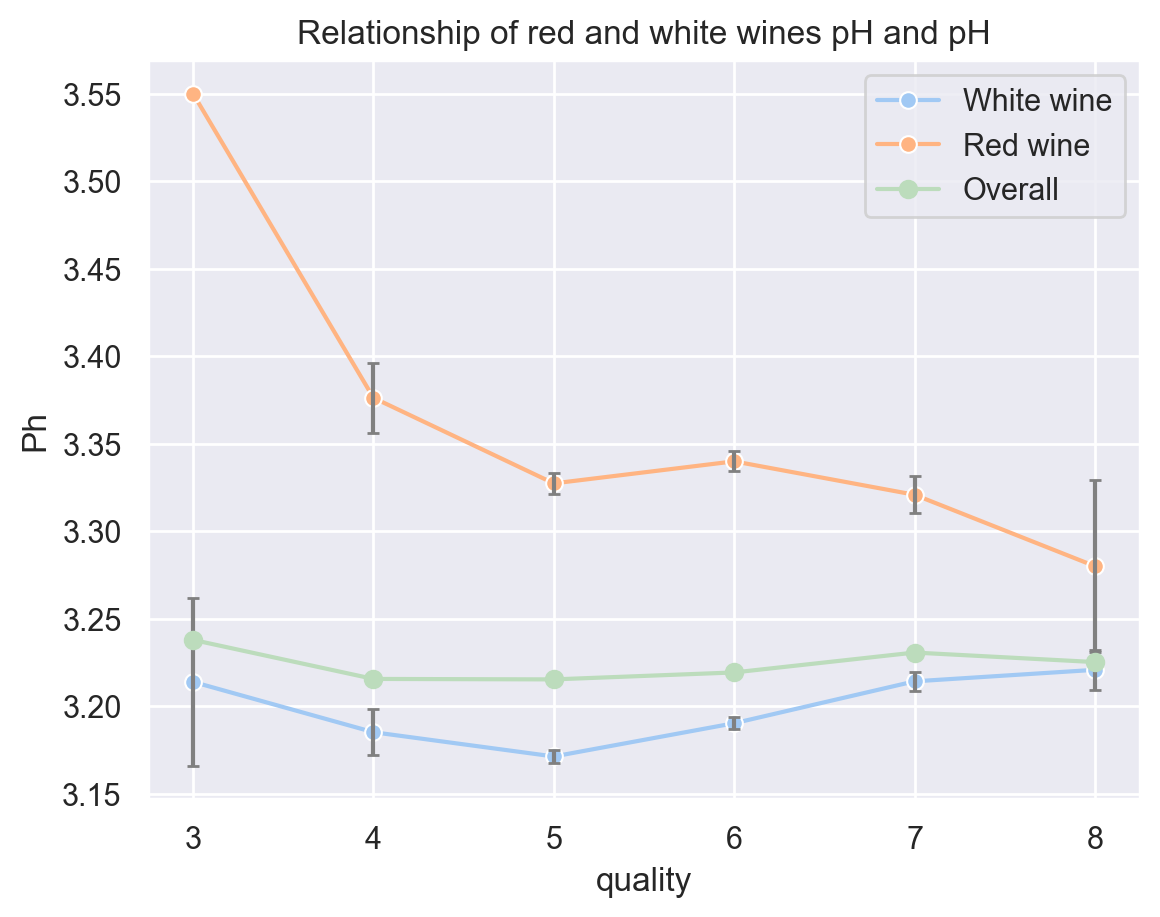

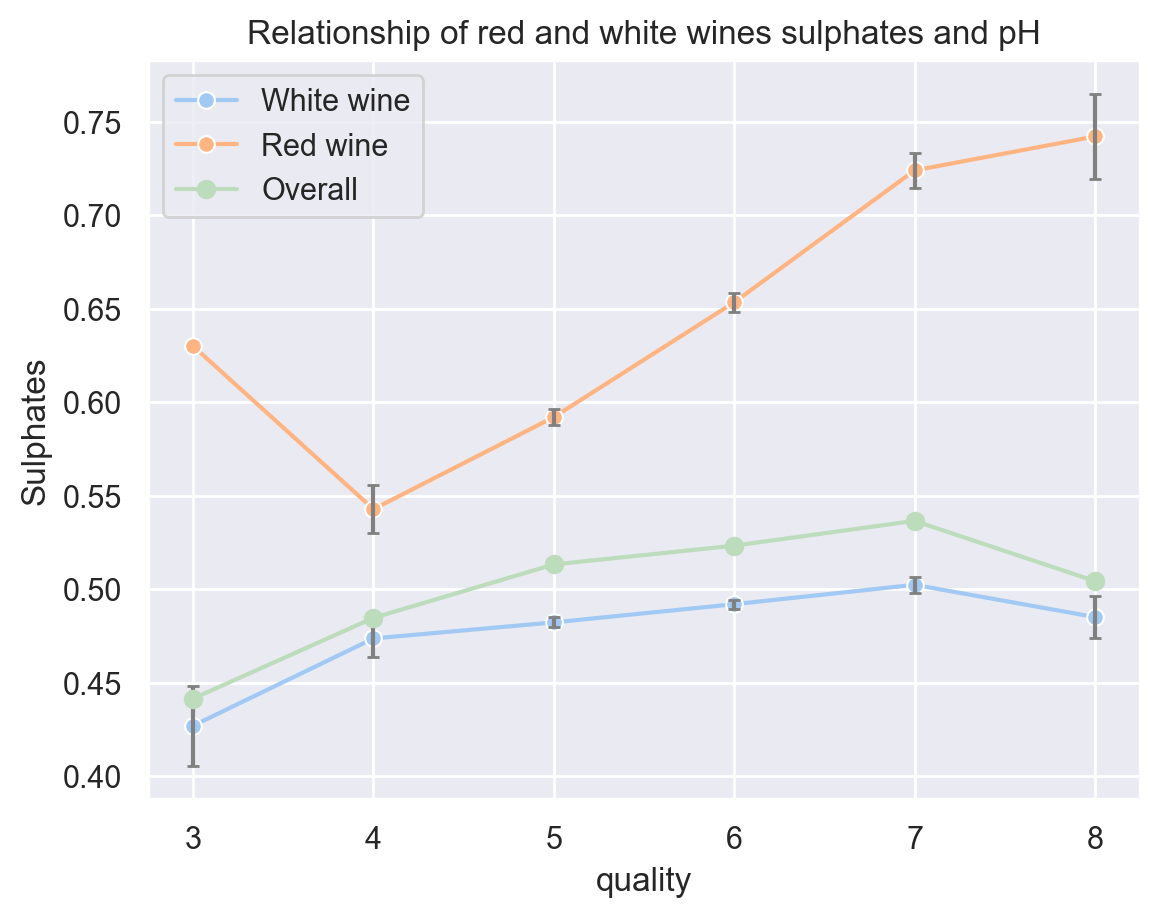

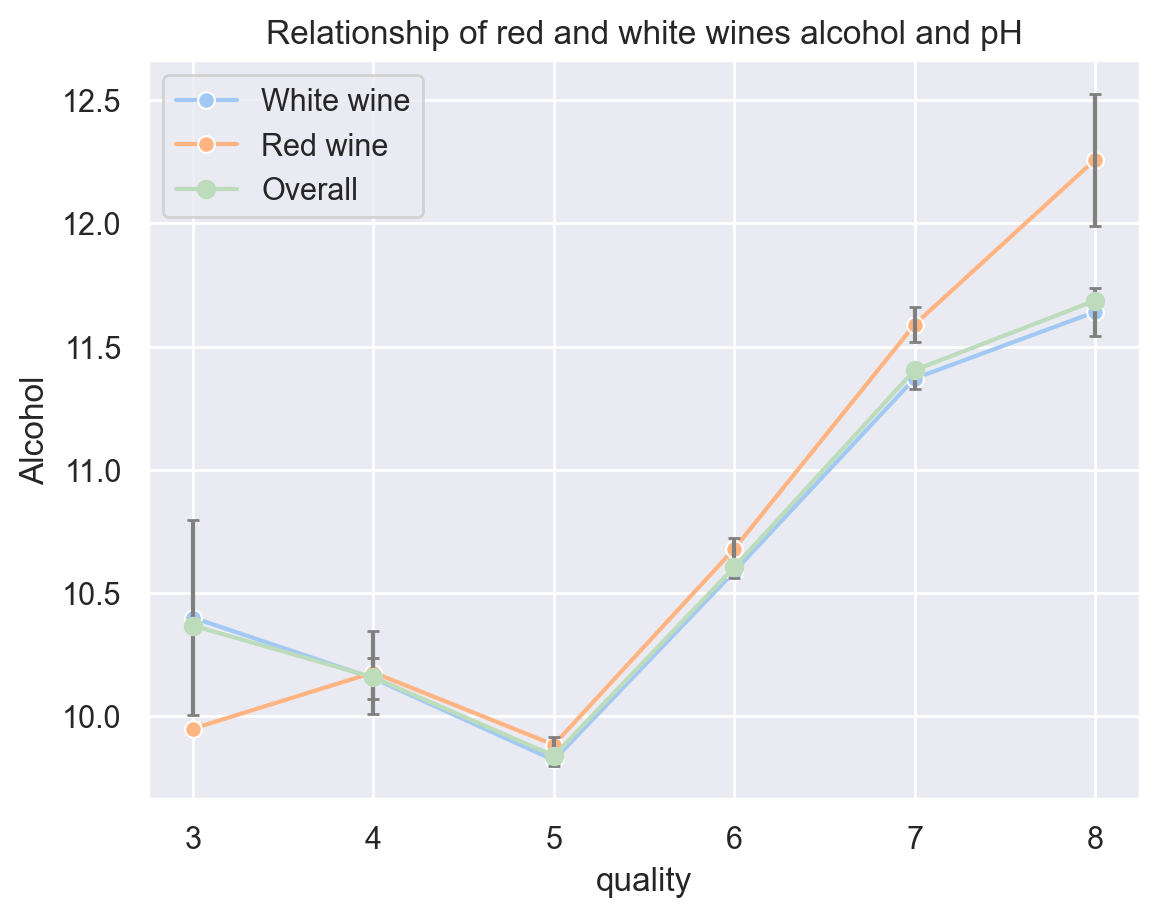

ValueError: Length of tuple vectors must match length of `data` when both are used, but `data` has length 12 and the vector passed to `y` has length 2.

In [552]:
def produce_scatter_plot(column_name:str, y_label:str) -> None:
    # Group by "quality" and "colour" and calculate the mean and confidence interval
    mean_data = outliers_removed_data.groupby(["quality", "colour"]).agg(["mean", "sem"])
    
    # Reset index to flatten the multi-level columns
    mean_data = mean_data.reset_index()
    
    # Plot the lineplot with error bars
    sns.lineplot(
        data=mean_data,
        x="quality",
        y=(column_name, "mean"),  # Specify the column for y-values
        hue="colour",
        marker="o",  # Use markers for data points
    )
    
    # Add error bars with capsize
    plt.errorbar(
        x=mean_data["quality"],
        y=mean_data[(column_name, "mean")],
        yerr=mean_data[(column_name, "sem")],
        linestyle="None",  # No line connecting error bars
        color="gray",  # Color of error bars
        capsize=2,  # Adjust capsize as needed
    )
    
    plt.ylabel(y_label)
    
    # Calculate overall mean for both wine colors
    overall_mean = outliers_removed_data.groupby("quality")[column_name].mean()
 
    # Plot the overall line
    
    plt.plot(
        overall_mean.index,
        overall_mean.values,
        color=sns.light_palette("green")[1],  # Choose a color for the overall line
        marker="o",  # Use markers for data points,
        linestyle="-",
        label="Overall",  # Label for the legend
    )
    
    # Customize the legend labels
    handles, labels = plt.gca().get_legend_handles_labels()
    labels[0] = "White wine"
    labels[1] = "Red wine"
    
    
    # Add the legend with the updated handles and labels
    plt.legend(handles, labels)
    
    # Add title
    plt.title(f"Relationship of red and white wines {column_name} and pH")
    
    # Show the plot
    plt.show()
for element in outliers_removed_data.columns:
    produce_scatter_plot(element,f"{element}".capitalize())

[(0.9197652656492237, 0.9527224554855785, 0.9196755184291894),
 (0.7358122125193789, 0.8625701212512079, 0.7357404147433515),
 (0.5518591593895341, 0.7724177870168373, 0.5518053110575136),
 (0.36790610625968945, 0.6822654527824668, 0.36787020737167575),
 (0.18395305312984467, 0.5921131185480961, 0.18393510368583788),
 (0.0, 0.5019607843137255, 0.0)]